**Importing Libraries**

In [197]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode()
import plotly.io as pio
pio.renderers.default = 'colab'
pio.templates.default = "plotly_white"
pd.options.plotting.backend = "plotly"
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn import model_selection
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder

# Classification: Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc


**Loading the Data**

We created three data frames (df), one for each csv file. Also, we vizualize some information about each df.

In [198]:
BASE_PATH = "/Users/patriciapatrao/Desktop/Nuclio School/11. Final Project/data"


df_com = pd.read_csv(f'{BASE_PATH}/commercial_activity_df.csv')
df_prod = pd.read_csv(f'{BASE_PATH}/products_df.csv')
df_soc = pd.read_csv(f'{BASE_PATH}/sociodemographic_df.csv')

**Context**
In the first email received from Carol (CEO), it is possible to assume that the business understanding is that the company is realigning its business strategy to increase the market penetration of its current product portfolio, aiming to enhance the profitability of the existing customer base. The plan is to reduce the resource-intensive activity of acquiring new customers and wish to conduct a comprehensive analysis to assist in making strategic decisions.


So lets start by focousing on the commercial_activity data frame.

In [199]:
df_com

Unnamed: 0   pk_cid pk_partition  entry_date entry_channel  \
0                 0  1375586   2018-01-28  2018-01-12           KHL   
1                 1  1050611   2018-01-28  2015-08-10           KHE   
2                 2  1050612   2018-01-28  2015-08-10           KHE   
3                 3  1050613   2018-01-28  2015-08-10           KHD   
4                 4  1050614   2018-01-28  2015-08-10           KHE   
...             ...      ...          ...         ...           ...   
5962919    13647304  1166765   2019-05-28  2016-08-14           KHE   
5962920    13647305  1166764   2019-05-28  2016-08-14           KHE   
5962921    13647306  1166763   2019-05-28  2016-08-14           KHE   
5962922    13647307  1166789   2019-05-28  2016-08-14           KHE   
5962923    13647308  1550586   2019-05-28  2019-05-13           NaN   

         active_customer             segment  
0                    1.0   02 - PARTICULARES  
1                    0.0  03 - UNIVERSITARIO  
2                    0.0  03 - UNIVERSITARIO  
3                    0.0  03 - UNIVERSITARIO  
4                    1.0  03 - UNIVERSITARIO  
...                  ...                 ...  
5962919              0.0  03 - UNIVERSITARIO  
5962920              0.0  03 - UNIVERSITARIO  
5962921              1.0   02 - PARTICULARES  
5962922              0.0  03 - UNIVERSITARIO  
5962923              1.0                 NaN  

[5962924 rows x 7 columns]

In [200]:
# Total of different costumers
total_unique_pk_cid = len(df_com['pk_cid'].unique())
total_unique_pk_cid

456373

*Unnamed: 0*: will be used to merge all 3 Data Frames.

*pk_partition*: is the date on which the data was ingested or loaded into the system.  It helps in organizing and managing the data by associating each record with its corresponding ingestion date.

*pk_cid*: This column contains the unique identifier of each customer.

*entry_date*: This column indicates the entry date of the commercial activity. It has to be passed as date and not an object.

*entry_channel*: This column indicates the entry channel associated with the commercial activity.

*active_customer*: This column indicates whether the customer is active (non-null value) or not (null value).

*segment*: This column indicates the segment to which the customer belongs.

In [201]:
# Converting entry_date from object to a date time
df_com['entry_date'] = pd.to_datetime(df_com['entry_date'], errors='coerce')
df_com['pk_partition'] = pd.to_datetime(df_com['pk_partition'], errors='coerce')

In [202]:
# Converting active_customer variable from float to interger
df_com['active_customer'] = df_com['active_customer'].astype(int)

In the 'entry_date' column, we have identified certain errors where dates were incorrectly marked as February 29th in non-leap years. To ensure data consistency, we will rectify these errors by modifying all such dates to February 28th.

In [203]:
# Replacing all the February 29th for 28th to become a valide date
df_com['entry_date'] = df_com['entry_date'].apply(lambda x: x.replace(day=28) if x.month == 2 and x.day == 29 else x)
df_com['pk_partition'] = df_com['pk_partition'].apply(lambda x: x.replace(day=28) if x.month == 2 and x.day == 29 else x)

In [204]:
# Checking for missing values
print(df_com['entry_date'].isnull().sum())
print(df_com['pk_partition'].isnull().sum())

6413
0


Since there are only a few null values present (comparing to the total amount of row - 5962924), it is recommended to drop them for better data integrity and analysis.

In [205]:
# Dealing with the missing values
df_com.dropna(subset=['entry_date'], inplace=True)

When evaluating the entry dates of customers in the dataset, it is important to note that having only a few entries from 2019 is expected, as the year is not yet halfway through.

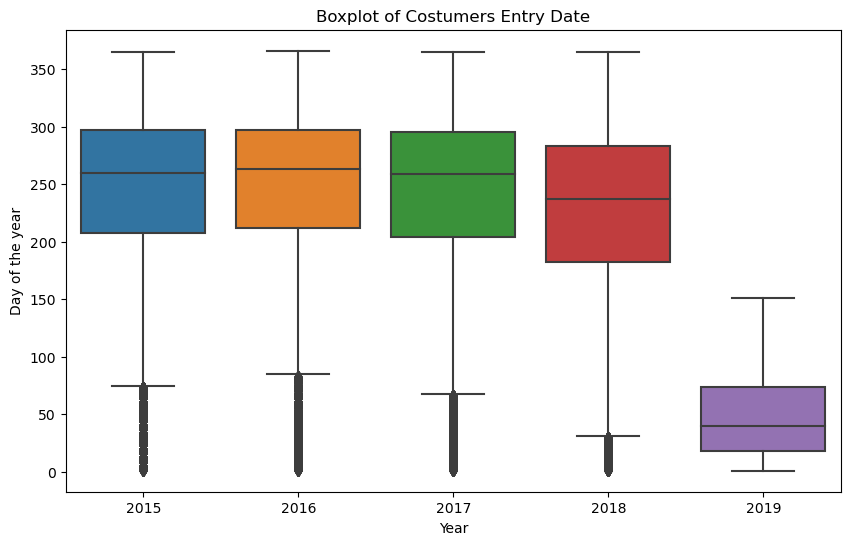

In [206]:
# Creating Boxplots of customers entry date by diferent years
plt.figure(figsize=(10, 6))

sns.boxplot(x=df_com['entry_date'].dt.year, y=df_com['entry_date'].dt.dayofyear)

plt.xlabel('Year')
plt.ylabel('Day of the year')
plt.title('Boxplot of Costumers Entry Date')
plt.show()

The 'pk_partition' column represents the data ingestion date. Let's explore how it evolves over time to gain insights into the temporal patterns and trends in the dataset.

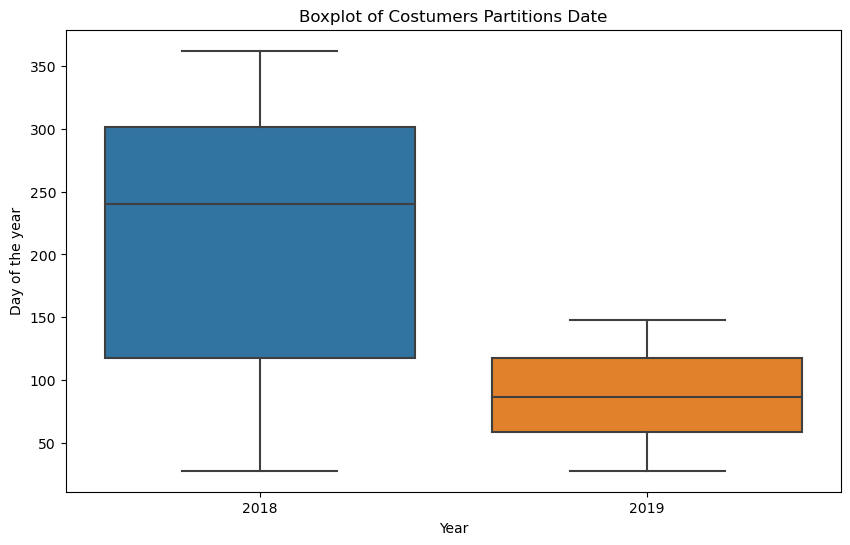

In [207]:
# Creating Boxplots of customers partition date
plt.figure(figsize=(10, 6))

sns.boxplot(x=df_com['pk_partition'].dt.year, y=df_com['pk_partition'].dt.dayofyear)

plt.xlabel('Year')
plt.ylabel('Day of the year')
plt.title('Boxplot of Costumers Partitions Date')
plt.show()

In [208]:
df_com['entry_channel'].isnull().sum()

132083

In [209]:
# Dealing with the missing values
df_com['entry_channel'] = df_com['entry_channel'].fillna('No Info')

In [210]:
df_com['segment'].isnull().sum()

133009

To handle missing segment information for certain customers in subsequent periods, I will employ a strategy of filling in these missing values with the most recent segment information available. This approach ensures that we have complete and consistent data for analysis and modeling purposes.

In [211]:
# Filling some of segment missing values
df_com['segment'] = df_com.groupby('pk_cid')['segment'].fillna(method='bfill')

In [212]:
df_com['segment'].isnull().sum()

9247

In [213]:
# Filling the rest of the missing values with NO INFO
df_com['segment'] = df_com['segment'].fillna('04 - NO INFO')

In [214]:
from collections import Counter

# Counting how many costumers in each segment type
Counter(df_com.segment)

Counter({'02 - PARTICULARES': 1873865,
         '03 - UNIVERSITARIO': 3973938,
         '01 - TOP': 99461,
         '04 - NO INFO': 9247})

In [215]:
df_com['active_customer'].describe()

count    5.956511e+06
mean     4.033066e-01
std      4.905613e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: active_customer, dtype: float64

From the 'active_costumer' description, it can be observed that approximately 40.3% of customers are classified as active. This binary variable indicates whether a customer is active (assigned a value of 1) or inactive (assigned a value of 0).

We can further explore the behavior of customers over time by analyzing their patterns based on both the "entry_date" and "pk_partition" variables. This analysis will provide insights into how customer activity and behavior may change over different time periods, allowing us to identify any trends or patterns that may influence their purchasing decisions.

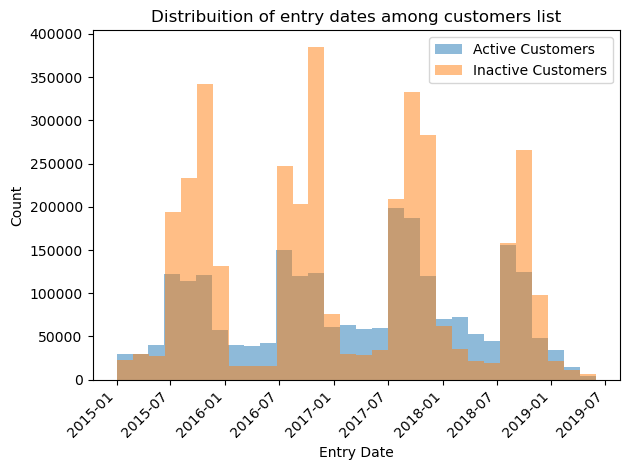

In [216]:
# Filtering active/inactive clients
active_customer = df_com[df_com['active_customer'] == 1]
inactive_customer = df_com[df_com['active_customer'] == 0]

# Histogramof entry dates for active and inactive customers
plt.hist(active_customer['entry_date'], bins=30, alpha=0.5, label='Active Customers')
plt.hist(inactive_customer['entry_date'], bins=30, alpha=0.5, label='Inactive Customers')

plt.xlabel('Entry Date')
plt.ylabel('Count')
plt.title('Distribuition of entry dates among customers list')
plt.legend()

plt.xticks(rotation=45, ha='right')
plt.subplots_adjust(bottom=0.15)
plt.tight_layout()

plt.show()

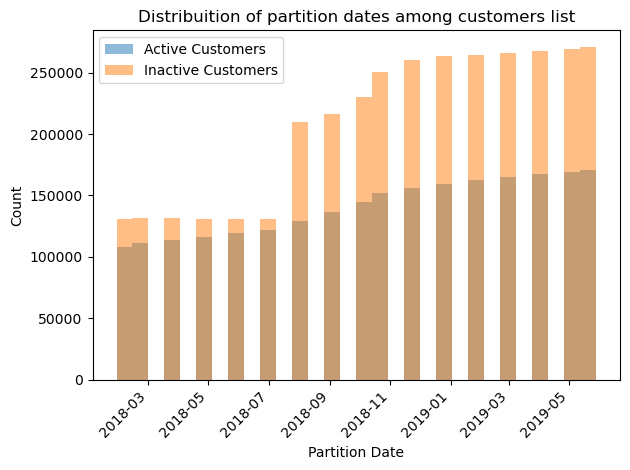

In [217]:
# Histogramof entry dates for active and inactive customers
plt.hist(active_customer['pk_partition'], bins=30, alpha=0.5, label='Active Customers')
plt.hist(inactive_customer['pk_partition'], bins=30, alpha=0.5, label='Inactive Customers')

plt.xlabel('Partition Date')
plt.ylabel('Count')
plt.title('Distribuition of partition dates among customers list')
plt.legend()

plt.xticks(rotation=45, ha='right')
plt.subplots_adjust(bottom=0.15)
plt.tight_layout()

plt.show()

There is a prominent pattern observed in this plot, indicating that a considerable number of clients tend to subscribe towards the end of the year. This trend suggests that initiating marketing campaigns slightly earlier than this period may be an opportune moment to acquire new customers in the future. However, for now, our primary focus should be on our existing customers, encouraging them to become active and to make more purchases.

In [218]:
# Lets calculate the percentage of actve cutomers per segment
active_customers_seg_per = df_com.groupby('segment')['active_customer'].mean()
active_customers_seg_per

segment
01 - TOP              0.944601
02 - PARTICULARES     0.617661
03 - UNIVERSITARIO    0.289234
04 - NO INFO          0.166216
Name: active_customer, dtype: float64

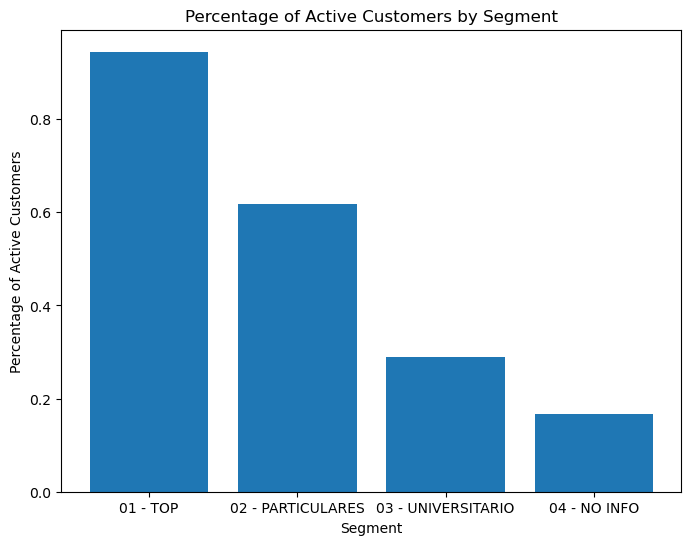

In [219]:
# Percentage of Active Customers in each Segment
act_seg_per = df_com.groupby('segment')['active_customer'].mean().reset_index()

plt.figure(figsize=(8, 6))
plt.bar(act_seg_per['segment'], act_seg_per['active_customer'])

plt.xlabel('Segment')
plt.ylabel('Percentage of Active Customers')
plt.title('Percentage of Active Customers by Segment')

plt.show()


This output highlights the fact that our TOP customers are more active compared to other segments. Given that a majority of our customers fall under the UNIVERSITARIOS category, it is essential to concentrate our marketing campaigns on this group with the aim of increasing their level of activity, as they currently exhibit the lowest level of engagement.

**Product Penetration Analysis**


Now we are Calculating the penetration of the current product in the existing customer base.Then Identifing products with lower penetration and focus on strategies to increase their adoption among existing customers

In [220]:
df_prod

Unnamed: 0   pk_cid pk_partition  short_term_deposit  loans  \
0                 0  1375586   2018-01-28                   0      0   
1                 1  1050611   2018-01-28                   0      0   
2                 2  1050612   2018-01-28                   0      0   
3                 3  1050613   2018-01-28                   1      0   
4                 4  1050614   2018-01-28                   0      0   
...             ...      ...          ...                 ...    ...   
5962919    13647304  1166765   2019-05-28                   0      0   
5962920    13647305  1166764   2019-05-28                   0      0   
5962921    13647306  1166763   2019-05-28                   0      0   
5962922    13647307  1166789   2019-05-28                   0      0   
5962923    13647308  1550586   2019-05-28                   0      0   

         mortgage  funds  securities  long_term_deposit  em_account_pp  \
0               0      0           0                  0              0   
1               0      0           0                  0              0   
2               0      0           0                  0              0   
3               0      0           0                  0              0   
4               0      0           0                  0              0   
...           ...    ...         ...                ...            ...   
5962919         0      0           0                  0              0   
5962920         0      0           0                  0              0   
5962921         0      0           0                  0              0   
5962922         0      0           0                  0              0   
5962923         0      0           0                  0              0   

         credit_card  payroll  pension_plan  payroll_account  emc_account  \
0                  0      0.0           0.0                0            0   
1                  0      0.0           0.0                0            0   
2                  0      0.0           0.0                0            0   
3                  0      0.0           0.0                0            0   
4                  0      0.0           0.0                0            0   
...              ...      ...           ...              ...          ...   
5962919            0      0.0           0.0                0            0   
5962920            0      0.0           0.0                0            0   
5962921            0      0.0           0.0                0            0   
5962922            0      0.0           0.0                0            0   
5962923            0      0.0           0.0                0            0   

         debit_card  em_account_p  em_acount  
0                 0             0          1  
1                 0             0          1  
2                 0             0          1  
3                 0             0          0  
4                 0             0          1  
...             ...           ...        ...  
5962919           0             0          1  
5962920           0             0          1  
5962921           0             0          1  
5962922           0             0          1  
5962923           0             0          1  

[5962924 rows x 18 columns]

In [221]:
# Converting entry_date from object to a date time
df_prod['pk_partition'] = pd.to_datetime(df_prod['pk_partition'], errors='coerce')

Within this dataframe, a **significant number of columns are binary**, serving to indicate whether each customer has acquired a specific product or not. These binary variables provide valuable information on customer product preferences and purchasing behavior, enabling us to further analyze their buying patterns and tailor marketing strategies accordingly

In [222]:
total_unique_pk_cid_prod = len(df_prod['pk_cid'].unique())
print(total_unique_pk_cid_prod)
print(df_prod['pk_cid'].isnull().sum())

456373
0


In [223]:
# Converting floats to integers.
df_prod['payroll'] = pd.to_numeric(df_prod['payroll'], errors='coerce').astype('Int64')
df_prod['pension_plan'] = pd.to_numeric(df_prod['pension_plan'], errors='coerce').astype('Int64')

In [224]:
# Filling in the missing values with the median, which is less sensitive to outliers.
median_payroll = df_prod['payroll'].median()
df_prod['payroll'].fillna(median_payroll, inplace=True)

median_pension_plan = df_prod['pension_plan'].median()
df_prod['pension_plan'].fillna(median_pension_plan, inplace=True)

In [225]:
# Creating a new column that represents the sum of all products acquired by each customer.
df_prod['total_products'] = df_prod.iloc[:, 2:].sum(axis=1)

/var/folders/gx/5k88wzkx0zv8bsfz2nt93d0h0000gn/T/ipykernel_777/1801072503.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



By analyzing the **frequency of product purchases**, it is possible to gain insights into customer preferences, identify popular products, and understand the demand for specific items. This information is valuable for *inventory management, marketing campaigns, and overall business strategy*, as it **helps to optimize product offerings and enhance customer satisfaction**.

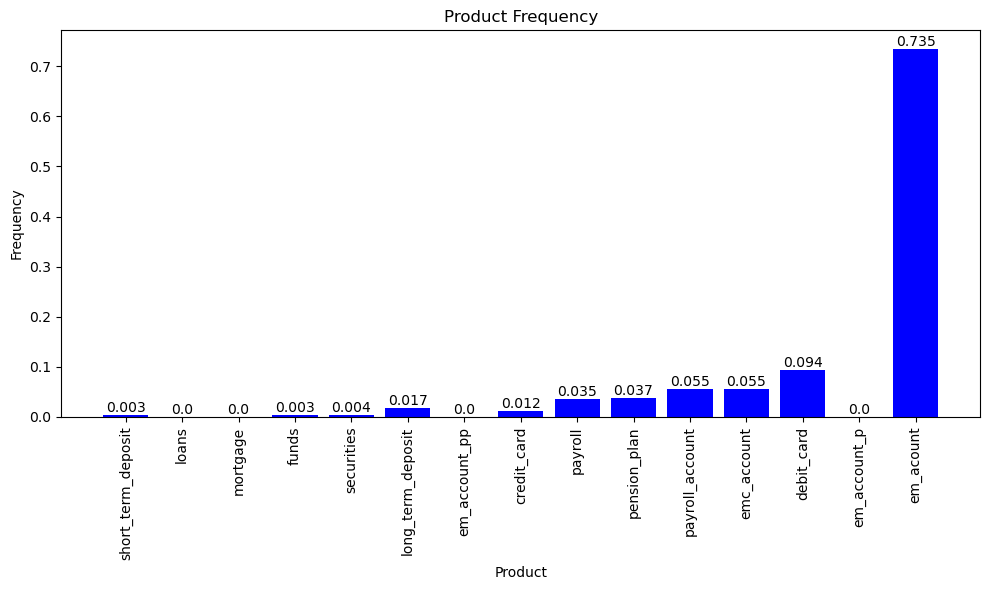

In [226]:
# Calculating product frequency
product_frequency = (df_prod[df_prod.columns[3:-1]].sum() / len(df_prod)).round(3)

x_values = np.arange(len(df_prod.columns[3:-1]))

plt.figure(figsize=(10, 6))

plt.bar(x_values, product_frequency, color='blue')
plt.xlabel('Product')
plt.ylabel('Frequency')
plt.title('Product Frequency')

plt.xticks(x_values, df_prod.columns[3:-1], rotation='vertical')

# Showing the Frequency values for each product
for i, freq in enumerate(product_frequency):
    plt.text(x=i, y=freq, s=str(freq), ha='center', va='bottom')

plt.tight_layout()

plt.show()


Based on the provided figure, it is evident that **customers highly appreciate certain products**: *em_account, debit card, emc_account, payroll account, and pension plan*.

These products have garnered significant interest and usage among customers, indicating their importance and value within the customer base. Recognizing these preferred products allows businesses to focus their efforts on further enhancing and promoting these offerings to meet customer demand and maximize customer satisfaction.

Explore existing customers' buying patterns, such as *frequency, average transaction value, and most purchased products*. And then, Identify opportunities to encourage additional or cross-buying by offering discounts, promotional packages or personalized recommendations.

In [227]:
df_prod.iloc[:, 2:]

pk_partition  short_term_deposit  loans  mortgage  funds  securities  \
0         2018-01-28                   0      0         0      0           0   
1         2018-01-28                   0      0         0      0           0   
2         2018-01-28                   0      0         0      0           0   
3         2018-01-28                   1      0         0      0           0   
4         2018-01-28                   0      0         0      0           0   
...              ...                 ...    ...       ...    ...         ...   
5962919   2019-05-28                   0      0         0      0           0   
5962920   2019-05-28                   0      0         0      0           0   
5962921   2019-05-28                   0      0         0      0           0   
5962922   2019-05-28                   0      0         0      0           0   
5962923   2019-05-28                   0      0         0      0           0   

         long_term_deposit  em_account_pp  credit_card  payroll  pension_plan  \
0                        0              0            0        0             0   
1                        0              0            0        0             0   
2                        0              0            0        0             0   
3                        0              0            0        0             0   
4                        0              0            0        0             0   
...                    ...            ...          ...      ...           ...   
5962919                  0              0            0        0             0   
5962920                  0              0            0        0             0   
5962921                  0              0            0        0             0   
5962922                  0              0            0        0             0   
5962923                  0              0            0        0             0   

         payroll_account  emc_account  debit_card  em_account_p  em_acount  \
0                      0            0           0             0          1   
1                      0            0           0             0          1   
2                      0            0           0             0          1   
3                      0            0           0             0          0   
4                      0            0           0             0          1   
...                  ...          ...         ...           ...        ...   
5962919                0            0           0             0          1   
5962920                0            0           0             0          1   
5962921                0            0           0             0          1   
5962922                0            0           0             0          1   
5962923                0            0           0             0          1   

         total_products  
0                   1.0  
1                   1.0  
2                   1.0  
3                   1.0  
4                   1.0  
...                 ...  
5962919             1.0  
5962920             1.0  
5962921             1.0  
5962922             1.0  
5962923             1.0  

[5962924 rows x 17 columns]

In [228]:
# Calculate purchase behavior metrics:

# Average purchase frequency of customers
purchase_frequency = round(df_prod.iloc[:, 3:-1].sum(axis=1).mean(),3)
# Average value of transactions
average_transaction_value = round(df_prod.iloc[:, 3:-1].sum().mean(),2)
# Identifying the top five best-selling products
top_products = df_prod.iloc[:, 3:-1].sum().nlargest(6)

# Print purchase behavior metrics
print(f"Purchase Frequency: {purchase_frequency}")
print(f"Average Transaction Value: {average_transaction_value}")
print(f"Top Products:\n{top_products}")

Purchase Frequency: 1.049
Average Transaction Value: 416967.87
Top Products:
em_acount          4381602
debit_card          562968
payroll_account     329420
emc_account         326961
pension_plan        217802
payroll             205787
dtype: int64


In [229]:
df_soc

Unnamed: 0   pk_cid pk_partition country_id  region_code gender  age  \
0                 0  1375586   2018-01-28         ES         29.0      H   35   
1                 1  1050611   2018-01-28         ES         13.0      V   23   
2                 2  1050612   2018-01-28         ES         13.0      V   23   
3                 3  1050613   2018-01-28         ES         50.0      H   22   
4                 4  1050614   2018-01-28         ES         50.0      V   23   
...             ...      ...          ...        ...          ...    ...  ...   
5962919    13647304  1166765   2019-05-28         ES         50.0      V   22   
5962920    13647305  1166764   2019-05-28         ES         26.0      V   23   
5962921    13647306  1166763   2019-05-28         ES         50.0      H   47   
5962922    13647307  1166789   2019-05-28         ES         50.0      H   22   
5962923    13647308  1550586   2019-05-28         ES         28.0      H   37   

        deceased     salary  
0              N   87218.10  
1              N   35548.74  
2              N  122179.11  
3              N  119775.54  
4              N        NaN  
...          ...        ...  
5962919        N   43912.17  
5962920        N   23334.99  
5962921        N        NaN  
5962922        N  199592.82  
5962923        N        NaN  

[5962924 rows x 9 columns]

In [230]:
# Converting entry_date from object to a date time
df_soc['pk_partition'] = pd.to_datetime(df_soc['pk_partition'], errors='coerce')

In [231]:
total_unique_pk_cid_soc = len(df_soc['pk_cid'].unique())
print(total_unique_pk_cid_soc)
print(df_soc['pk_cid'].isnull().sum())

456373
0


In [232]:
df_soc.isnull().sum()

Unnamed: 0            0
pk_cid                0
pk_partition          0
country_id            0
region_code        2264
gender               25
age                   0
deceased              0
salary          1512103
dtype: int64

In [233]:
# Dealing with the missing values
df_soc['region_code'] = df_soc['region_code'].fillna('No Info')

In [234]:
df_soc['salary'].describe()

count    4.450821e+06
mean     1.158167e+05
std      1.995519e+05
min      1.202730e+03
25%      6.150063e+04
50%      8.865465e+04
75%      1.316699e+05
max      2.889440e+07
Name: salary, dtype: float64

The summary statistics for the 'salary' column show that the mean and median values are relatively close, with the median being 88,654.65.

By using the median to fill in the missing values, we aim to minimize the impact of potential outliers or extreme values that could skew the mean. Since the median represents the middle value in the dataset, it provides a more robust estimate of the central tendency and is less affected by extreme values.

Therefore, replacing the missing values with the median salary ensures that the imputed values are representative of the overall distribution and helps maintain the integrity and reliability of the dataset for subsequent analyses and modeling tasks.

In [235]:
# Filling the missing values with the median that is less sensible to outliers
median_salary = df_soc['salary'].median()
df_soc['salary'].fillna(median_salary, inplace=True)

In [236]:
df_soc.loc[df_soc['age'] < 18]

Unnamed: 0   pk_cid pk_partition country_id region_code gender  age  \
632             633  1051851   2018-01-28         ES        28.0      V   15   
633             634  1051852   2018-01-28         ES        28.0      H   12   
634             635  1051853   2018-01-28         ES        28.0      H    8   
635             636  1051854   2018-01-28         ES        28.0      H    6   
760             761  1052024   2018-01-28         ES        28.0      H   10   
...             ...      ...          ...        ...         ...    ...  ...   
5961866    13646251  1167918   2019-05-28         ES        28.0      V    7   
5961949    13646334  1168199   2019-05-28         ES         8.0      H    4   
5962615    13647000  1167196   2019-05-28         ES        47.0      H    4   
5962795    13647180  1166650   2019-05-28         ES        28.0      H   13   
5962804    13647189  1166639   2019-05-28         ES        28.0      V   16   

        deceased     salary  
632            N  487858.47  
633            N  487858.47  
634            N  487858.47  
635            N  263826.03  
760            N   58594.68  
...          ...        ...  
5961866        N  209715.09  
5961949        N  136641.81  
5962615        N  130692.45  
5962795        N  238449.18  
5962804        N  238449.18  

[35873 rows x 9 columns]

Targeting individuals under the age of 18 does not align with our business objectives. Therefore, we will exclude these 35873 customers from our analysis and marketing campaigns.

In [237]:
df_soc = df_soc.drop(df_soc[df_soc['age'] < 18].index)

In [238]:
# Group clients into age ranges (e.g., 18-25, 26-35, etc.)
age_ranges = [17, 25, 35, 45, 55, 65, 75, 85, 105]
df_soc['age_group'] = pd.cut(df_soc['age'], bins=age_ranges)

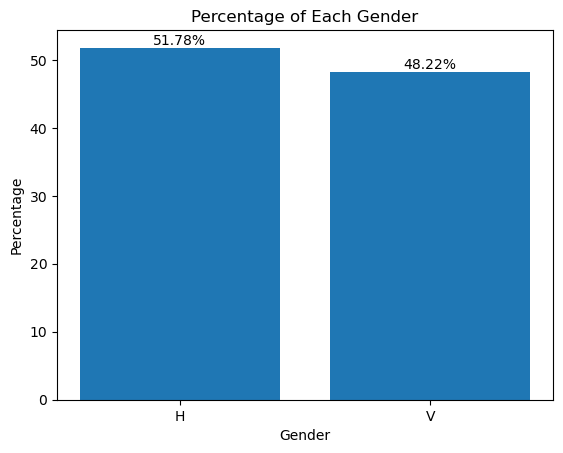

In [239]:
# Calculating each Gender percentage
gender_percentage = df_soc['gender'].value_counts(normalize=True) * 100

plt.bar(gender_percentage.index, gender_percentage.values)
plt.xlabel('Gender')
plt.ylabel('Percentage')
plt.title('Percentage of Each Gender')

for i, v in enumerate(gender_percentage.values):
    plt.text(i, v, f'{v:.2f}%', ha='center', va='bottom')

plt.show()

In [240]:
# Filling missing values on gender's column assuming the previous % of each one
gender_percentage = df_soc['gender'].value_counts(normalize=True) * 100
gender_fill_values = gender_percentage.index.tolist()

df_soc['gender'].fillna(pd.Series(np.random.choice(gender_fill_values, size=len(df_soc), p=gender_percentage.values/100)), inplace=True)

**Merging Data Frames**

In [241]:
# Merging all dfs
df_merge = pd.merge(df_com, df_prod, on='Unnamed: 0', how='inner')

In [242]:
df_final = pd.merge(df_merge, df_soc, on='Unnamed: 0', how='inner')

In [243]:
df_final.drop('Unnamed: 0', axis=1, inplace=True)

In [244]:
# New column with the year and month which converts each date value to a monthly period
df_final['pk_partition'] = pd.to_datetime(df_final['pk_partition'])
df_final['year_month'] = df_final['pk_partition'].dt.to_period('M')

In [245]:
df_final = df_final.loc[:, ~df_final.columns.duplicated()]

In [246]:
df_final

pk_cid_x pk_partition_x entry_date entry_channel  active_customer  \
0         1375586     2018-01-28 2018-01-12           KHL                1   
1         1050611     2018-01-28 2015-08-10           KHE                0   
2         1050612     2018-01-28 2015-08-10           KHE                0   
3         1050613     2018-01-28 2015-08-10           KHD                0   
4         1050614     2018-01-28 2015-08-10           KHE                1   
...           ...            ...        ...           ...              ...   
5920659   1166765     2019-05-28 2016-08-14           KHE                0   
5920660   1166764     2019-05-28 2016-08-14           KHE                0   
5920661   1166763     2019-05-28 2016-08-14           KHE                1   
5920662   1166789     2019-05-28 2016-08-14           KHE                0   
5920663   1550586     2019-05-28 2019-05-13       No Info                1   

                    segment  pk_cid_y pk_partition_y  short_term_deposit  \
0         02 - PARTICULARES   1375586     2018-01-28                   0   
1        03 - UNIVERSITARIO   1050611     2018-01-28                   0   
2        03 - UNIVERSITARIO   1050612     2018-01-28                   0   
3        03 - UNIVERSITARIO   1050613     2018-01-28                   1   
4        03 - UNIVERSITARIO   1050614     2018-01-28                   0   
...                     ...       ...            ...                 ...   
5920659  03 - UNIVERSITARIO   1166765     2019-05-28                   0   
5920660  03 - UNIVERSITARIO   1166764     2019-05-28                   0   
5920661   02 - PARTICULARES   1166763     2019-05-28                   0   
5920662  03 - UNIVERSITARIO   1166789     2019-05-28                   0   
5920663        04 - NO INFO   1550586     2019-05-28                   0   

         loans  ...   pk_cid  pk_partition  country_id  region_code  gender  \
0            0  ...  1375586    2018-01-28          ES         29.0       H   
1            0  ...  1050611    2018-01-28          ES         13.0       V   
2            0  ...  1050612    2018-01-28          ES         13.0       V   
3            0  ...  1050613    2018-01-28          ES         50.0       H   
4            0  ...  1050614    2018-01-28          ES         50.0       V   
...        ...  ...      ...           ...         ...          ...     ...   
5920659      0  ...  1166765    2019-05-28          ES         50.0       V   
5920660      0  ...  1166764    2019-05-28          ES         26.0       V   
5920661      0  ...  1166763    2019-05-28          ES         50.0       H   
5920662      0  ...  1166789    2019-05-28          ES         50.0       H   
5920663      0  ...  1550586    2019-05-28          ES         28.0       H   

         age  deceased     salary  age_group  year_month  
0         35         N   87218.10   (25, 35]     2018-01  
1         23         N   35548.74   (17, 25]     2018-01  
2         23         N  122179.11   (17, 25]     2018-01  
3         22         N  119775.54   (17, 25]     2018-01  
4         23         N   88654.65   (17, 25]     2018-01  
...      ...       ...        ...        ...         ...  
5920659   22         N   43912.17   (17, 25]     2019-05  
5920660   23         N   23334.99   (17, 25]     2019-05  
5920661   47         N   88654.65   (45, 55]     2019-05  
5920662   22         N  199592.82   (17, 25]     2019-05  
5920663   37         N   88654.65   (35, 45]     2019-05  

[5920664 rows x 34 columns]

In [247]:
df_final.drop(['pk_cid_y', 'pk_partition_y', 'pk_cid', 'pk_partition','entry_channel','entry_date'], axis=1, inplace=True)

In [248]:
df_final.rename(columns={'pk_cid_x': 'pk_cid',
                         'pk_partition_x': 'pk_partition'},
                inplace=True)

In [249]:
df_final.isnull().sum()

pk_cid                0
pk_partition          0
active_customer       0
segment               0
short_term_deposit    0
loans                 0
mortgage              0
funds                 0
securities            0
long_term_deposit     0
em_account_pp         0
credit_card           0
payroll               0
pension_plan          0
payroll_account       0
emc_account           0
debit_card            0
em_account_p          0
em_acount             0
total_products        0
country_id            0
region_code           0
gender                0
age                   0
deceased              0
salary                0
age_group             0
year_month            0
dtype: int64

In [250]:
# Total number os costumers in DF
len(df_final['pk_cid'].unique())

452197

# **Segmentation in 7 groups of clients**

In order to segment these customers based on relevant information, the following columns were elected: age, total number of products and salary. This segmentation will allow us to analyze and understand customer behavior more effectively.

In [251]:
# Sum of all products acquired
total_products = df_final.groupby('pk_cid')['total_products'].sum()

# Mean age over the period of time
average_age = df_final.groupby('pk_cid')['age'].mean()

# Mean salary over the period of time
average_salary = df_final.groupby('pk_cid')['salary'].mean()

# Adding segment
segment = df_final.groupby('pk_cid')['segment'].apply(lambda x: x.iloc[0])

# New DataFrame
segmentation_df = pd.DataFrame({
    'pk_cid': total_products.index,
    'total_products': total_products.values,
    'average_age': average_age.values.astype(float).round(2),
    'average_salary': average_salary.values,
    'segment': segment.values
})

segmentation_df


pk_cid  total_products  average_age  average_salary  \
0         15891             1.0        59.00        88654.65   
1         16063             0.0        62.00        88654.65   
2         16203             5.0        70.00        88654.65   
3         16502            13.0        57.89        88654.65   
4         17457            38.0        53.12       102405.75   
...         ...             ...          ...             ...   
452192  1553685             0.0        52.00        88654.65   
452193  1553686             0.0        30.00        88654.65   
452194  1553687             0.0        21.00        88654.65   
452195  1553688             0.0        43.00        88654.65   
452196  1553689             0.0        40.00        88654.65   

                  segment  
0       02 - PARTICULARES  
1       02 - PARTICULARES  
2       02 - PARTICULARES  
3       02 - PARTICULARES  
4       02 - PARTICULARES  
...                   ...  
452192       04 - NO INFO  
452193       04 - NO INFO  
452194       04 - NO INFO  
452195       04 - NO INFO  
452196       04 - NO INFO  

[452197 rows x 5 columns]

**Creating the 7 groups of similiar costumers**

In order to create the 7 groups of customers with similar characteristics, as requested by Erin, we considered the following relevant features: total_products, average_age, average_salary, and segment.


In [252]:
from sklearn.preprocessing import OneHotEncoder

# One-Hot-Encoding for the categorical variable: segment
encoder = OneHotEncoder(sparse=False, drop='first')
encoded_segment = encoder.fit_transform(segmentation_df[['segment']])
encoded_df = pd.DataFrame(encoded_segment, columns=encoder.get_feature_names_out(['segment']))

# Concatenate both dataframes
segmentation_data = pd.concat([segmentation_df[['total_products', 'average_age', 'average_salary']], encoded_df], axis=1)

# Normalizing features
segmentation_data = (segmentation_data - segmentation_data.mean()) / segmentation_data.std()

# K-means Model
n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(segmentation_data)

segmentation_df['cluster'] = kmeans.labels_

segmentation_df


pk_cid  total_products  average_age  average_salary  \
0         15891             1.0        59.00        88654.65   
1         16063             0.0        62.00        88654.65   
2         16203             5.0        70.00        88654.65   
3         16502            13.0        57.89        88654.65   
4         17457            38.0        53.12       102405.75   
...         ...             ...          ...             ...   
452192  1553685             0.0        52.00        88654.65   
452193  1553686             0.0        30.00        88654.65   
452194  1553687             0.0        21.00        88654.65   
452195  1553688             0.0        43.00        88654.65   
452196  1553689             0.0        40.00        88654.65   

                  segment  cluster  
0       02 - PARTICULARES        6  
1       02 - PARTICULARES        6  
2       02 - PARTICULARES        6  
3       02 - PARTICULARES        6  
4       02 - PARTICULARES        5  
...                   ...      ...  
452192       04 - NO INFO        2  
452193       04 - NO INFO        2  
452194       04 - NO INFO        2  
452195       04 - NO INFO        2  
452196       04 - NO INFO        2  

[452197 rows x 6 columns]

New Data frame with costumers grouped by each cluster, to avaliate each metric accordingly.

In [253]:
cluster_metrics = segmentation_df.groupby('cluster').agg({
    'total_products': ['sum', 'mean','median'],
    'average_age': 'mean',
    'average_salary': ['mean','median'],
    'segment': lambda x: x.mode().iloc[0]
})

cluster_metrics['average_salary'] = cluster_metrics['average_salary'].astype(int)

# Defining column names
cluster_metrics = cluster_metrics.rename(columns={
    'total_products': 'Total Products',
    'average_age': 'Average Age',
    'average_salary': 'Average Salary',
    'segment': 'Most Common Segment'
})


cluster_metrics

Total Products                   Average Age Average Salary            \
                   sum       mean median        mean           mean    median   
cluster                                                                         
0            3078355.0  18.169640   17.0   24.062534         105242     88654   
1             820309.0   8.771576    8.0   34.776042          98963     88654   
2               1785.0   0.206358    0.0   39.084645          88977     88654   
3                636.0  13.250000   17.0   32.834792       12157919  10130362   
4             467713.0   4.151323    1.0   22.383366         108410     88654   
5            1426431.0  47.923098   41.0   40.805412         111747     88654   
6             453831.0  11.903452   12.0   59.422648         115303     88654   

        Most Common Segment  
                   <lambda>  
cluster                      
0        03 - UNIVERSITARIO  
1         02 - PARTICULARES  
2              04 - NO INFO  
3        03 - UNIVERSITARIO  
4        03 - UNIVERSITARIO  
5         02 - PARTICULARES  
6         02 - PARTICULARES

The table above displays the seven distinct customer clusters identified in the dataset, each characterized by similar traits and behaviors. Among these clusters, Cluster 0 stands out as the largest group, consisting of 3078355 customers, followed by Cluster 5 with 1426431 customers. Cluster 0 also exhibits the highest average and median number of products purchased per customer (47.9 and 41, respectively). On the other hand, Cluster 3 has the lowest total number of products acquired (636), while Cluster 2 has the lowest average number of products per customer (0.2). The median number of products is the same for Clusters 0 and 3.

When considering the average age of customers within each cluster, Cluster 6 emerges as the oldest group, with an average age of 59 years, while Cluster 4 represents the youngest group, with an average age of 22 years. Interestingly, the age of customers does not necessarily correlate with their purchasing behavior or income level. Cluster 3, despite having the highest average salary, purchases the fewest number of products and belongs to the UNIVERSITARIO segment.

Based on this analysis, Cluster 5 appears to be the most promising target for focusing on the sheer quantity of products acquired, regardless of the amount of money spent. However, further examination will address the aspect of monetary value associated with these clusters.

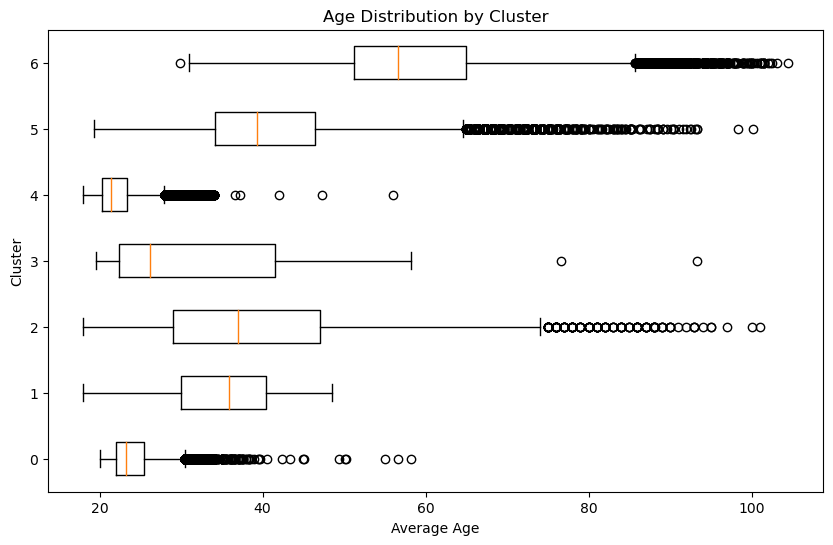

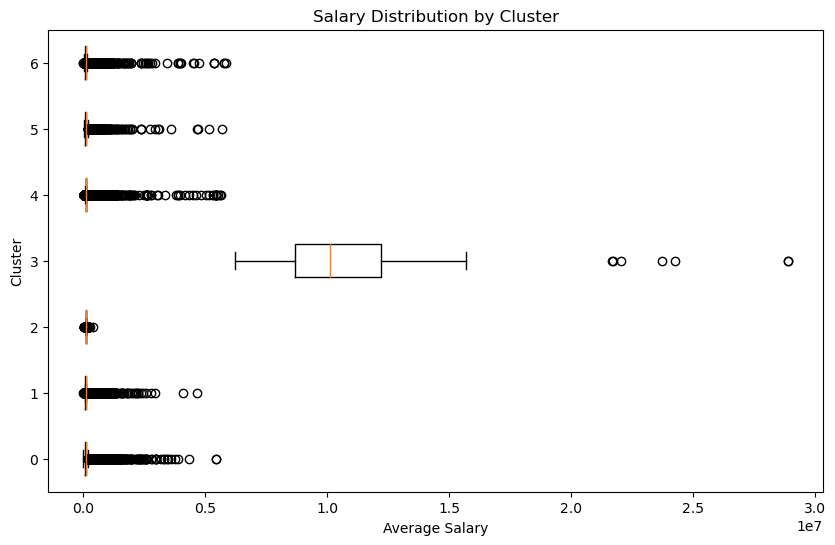

In [254]:
# Grouping data by cluster
grouped_df = segmentation_df.groupby('cluster')

# Box Plot to analyze Age Distribution in each cluster
plt.figure(figsize=(10, 6))
for cluster, data in grouped_df:
    plt.boxplot(data['average_age'], positions=[cluster], widths=0.5, vert=False)

plt.xlabel('Average Age')
plt.ylabel('Cluster')
plt.title('Age Distribution by Cluster')
plt.yticks(list(grouped_df.groups.keys()))

plt.show()

# Box Plot to analyze Salary Distribution in each cluster
plt.figure(figsize=(10, 6))
for cluster, data in grouped_df:
    plt.boxplot(data['average_salary'], positions=[cluster], widths=0.5, vert=False)

plt.xlabel('Average Salary')
plt.ylabel('Cluster')
plt.title('Salary Distribution by Cluster')
plt.yticks(list(grouped_df.groups.keys()))

plt.show()


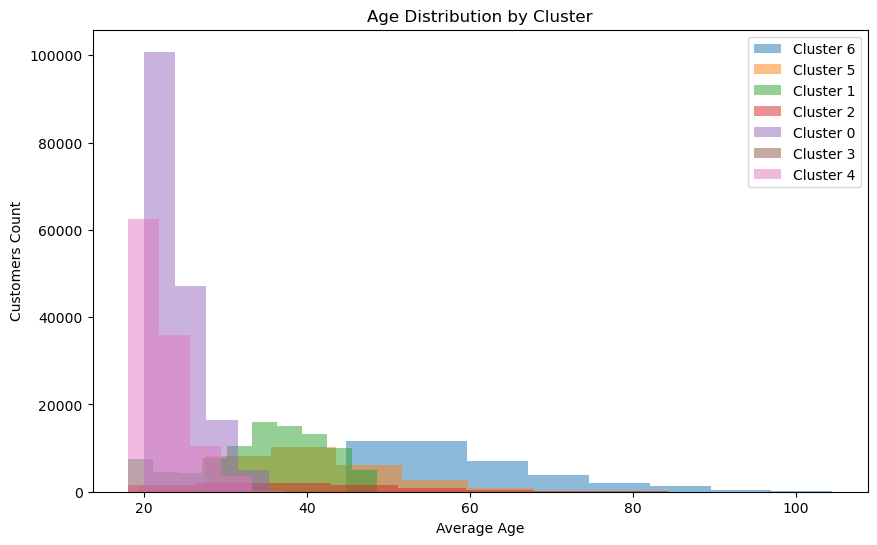

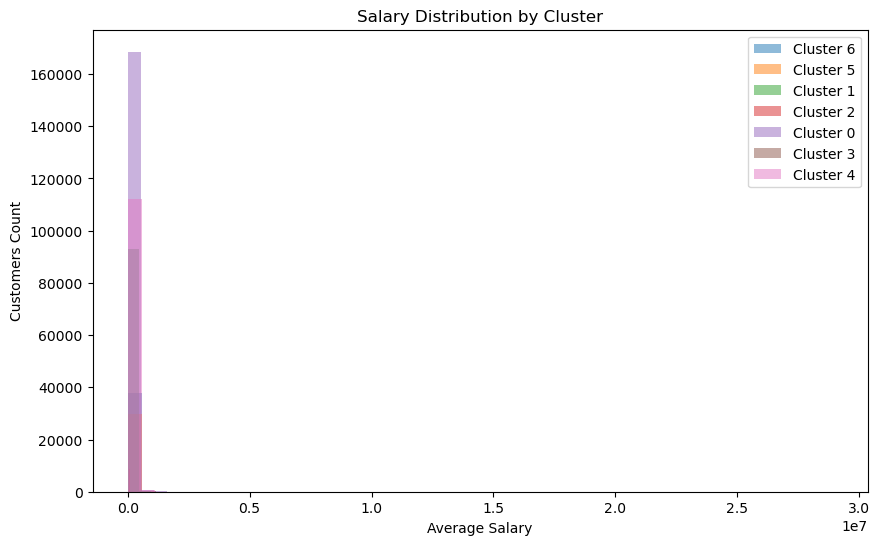

In [255]:
# Histogram of Age Distribution by Cluster
plt.figure(figsize=(10, 6))
for cluster in segmentation_df['cluster'].unique():
    data = segmentation_df[segmentation_df['cluster'] == cluster]
    plt.hist(data['average_age'], bins=10, alpha=0.5, label=f'Cluster {cluster}')

plt.xlabel('Average Age')
plt.ylabel('Customers Count')
plt.title('Age Distribution by Cluster')
plt.legend()

plt.show()

# Histogram of Salary Distribution by Cluster
plt.figure(figsize=(10, 6))
for cluster in segmentation_df['cluster'].unique():
    data = segmentation_df[segmentation_df['cluster'] == cluster]
    plt.hist(data['average_salary'], bins=10, alpha=0.5, label=f'Cluster {cluster}')

plt.xlabel('Average Salary')
plt.ylabel('Customers Count')
plt.title('Salary Distribution by Cluster')
plt.legend()

plt.show()


Upon analyzing the age and salary distributions across the client clusters, we gain valuable insights that can inform our marketing strategies and product offerings.

In terms of age distribution, clusters 0, 3, and 4 exhibit a higher concentration of younger customers, with clusters 0 and 3 showing less variability and outliers. On the other hand, clusters 2 and 5 have a wider range of age values and a higher concentration of outliers. This suggests that age can be a relevant factor in targeting customers for specific product purchases.

When examining the salary distribution, most clusters have relatively similar patterns, except for cluster 3, which stands out with higher wages. Cluster 2, on the other hand, has the lowest mean salary and a narrower range of values.

Interestingly, there is a general trend of higher mean age being associated with higher mean salary, with a few exceptions. Cluster 1 and 2 have higher mean ages but lower expected mean salary, while cluster 3 represents customers with higher wages.

These findings provide valuable insights for marketing purposes, highlighting the importance of considering age and salary as factors in understanding customer behavior and customizing product offerings to cater to specific clusters. By leveraging these insights, we can better target our marketing efforts and tailor our products to meet the needs and preferences of different customer segments.

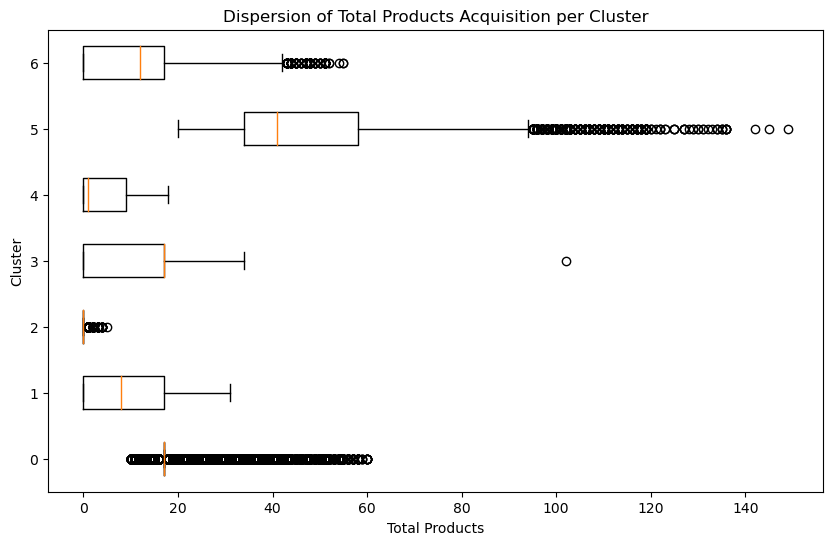

In [256]:
# Dispersion of Total Products Acquisition per Cluster

# Grouping by Cluster
grouped_df = segmentation_df.groupby('cluster')

# Box Plot
plt.figure(figsize=(10, 6))
for cluster, product in grouped_df:
    plt.boxplot(product['total_products'], positions=[cluster], widths=0.5, vert=False)

plt.xlabel('Total Products')
plt.ylabel('Cluster')
plt.title('Dispersion of Total Products Acquisition per Cluster')
plt.yticks(list(grouped_df.groups.keys()))

plt.show()

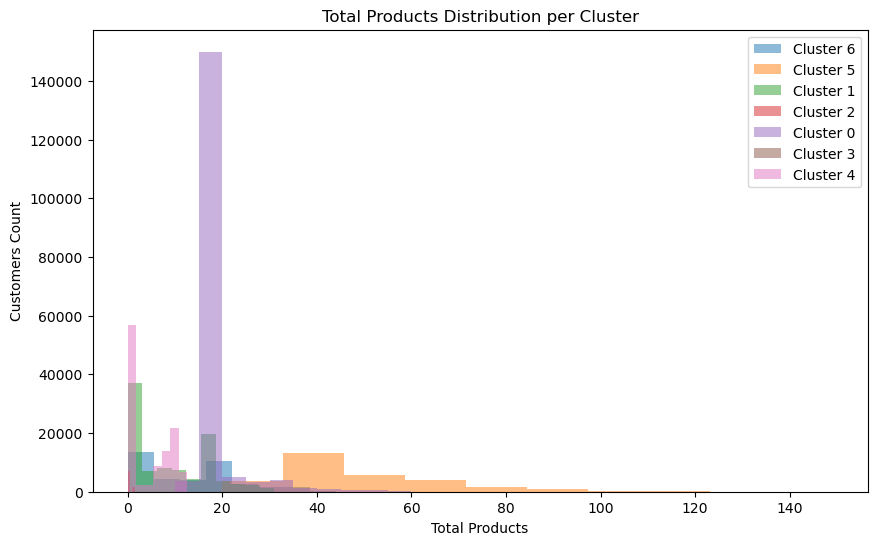

In [257]:
# Histogram of Total Products Distribution per Cluster
plt.figure(figsize=(10, 6))
for cluster in segmentation_df['cluster'].unique():
    data = segmentation_df[segmentation_df['cluster'] == cluster]
    plt.hist(data['total_products'], bins=10, alpha=0.5, label=f'Cluster {cluster}')

plt.xlabel('Total Products')
plt.ylabel('Customers Count')
plt.title('Total Products Distribution per Cluster')
plt.legend()

plt.show()

Here we can analyze the total acquisition of products per cluster and draw valuable insights for our marketing campaign. Cluster 5 stands out with the largest dispersion of values, indicating that these customers purchase the most products in the dataset. As previously mentioned, this cluster represents a diverse range of customers in terms of age, while their salary remains average. Additionally, many values in the boxplot for the total number of products are above the upper limit, suggesting that these customers consistently make purchases above the average and median of their cluster. Therefore, investing our marketing efforts in this cluster seems promising.

Cluster 6 also exhibits a significant number of product purchases, with many values exceeding the upper fence. Although the salary distribution is similar to that of cluster 5, the customers in cluster 6 are slightly older. Considering this, allocating some of our resources to target this cluster would be worthwhile.

On the other hand, cluster 2 demonstrates the lowest number of products purchased, and these customers have the lowest income. Moreover, cluster 2 has the highest dispersion of age values. As a result, it may be more effective to allocate our budget to other clusters instead.

In the case of cluster 3, although these customers do not purchase the majority of our products, they do make some purchases. Notably, they have the highest income. Targeting them with our premium and higher-priced products could yield favorable results.

By leveraging these insights and understanding the purchasing behavior of each cluster, we can make informed decisions on where to focus our marketing efforts and allocate resources effectively to maximize our sales potential.

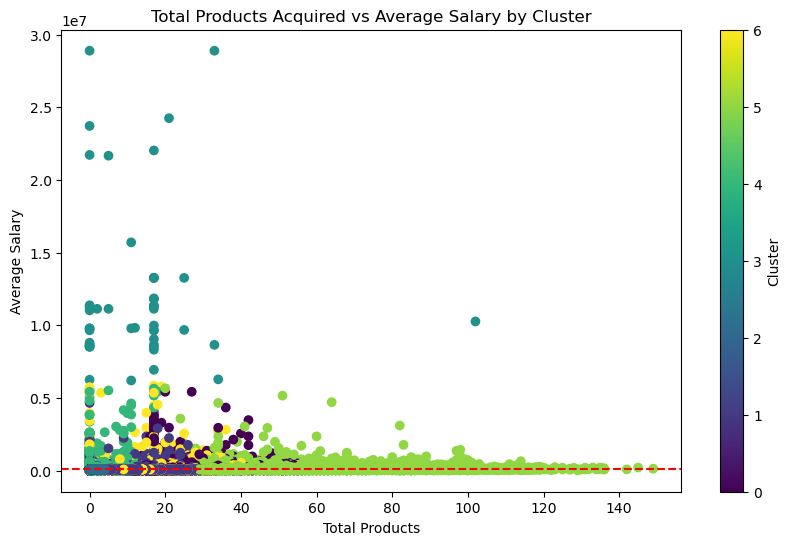

In [258]:
# Scatter Plot of the Relationship between Product Acquisition and Average Customer Salary in Each Cluster
plt.figure(figsize=(10, 6))
plt.scatter(segmentation_df['total_products'], segmentation_df['average_salary'], c=segmentation_df['cluster'])

plt.xlabel('Total Products')
plt.ylabel('Average Salary')
plt.title('Total Products Acquired vs Average Salary by Cluster')

plt.axhline(segmentation_df['average_salary'].mean(), color='red', linestyle='--')
plt.colorbar(label='Cluster')

plt.show()


From the scatter plot of the Relationship between Product Acquisition and Average Customer Salary in Each Cluster, we can observe that despite Cluster 3 having the highest salaries, it is not necessarily the cluster that acquires the highest quantity of products.

Cluster 5 stands out with the largest dispersion in the number of products purchased among customers, contrary to Clusters 1 and 2, where both the dispersion and quantity of purchases are low.

The red line in the scatter plot represents the average salary across all clusters. Most of the data points align closely to this line, indicating that the salary distribution among customers is relatively concentrated around similar values. This can also be verified in the cluster_metrics table, where the median salary across clusters is consistent at around €88 654, except for Cluster 3, which is significantly higher than the average.

Overall, these findings suggest that while salary may have some influence on product acquisition, other factors such as customer preferences and demographics may play a more significant role in determining purchase behavior.

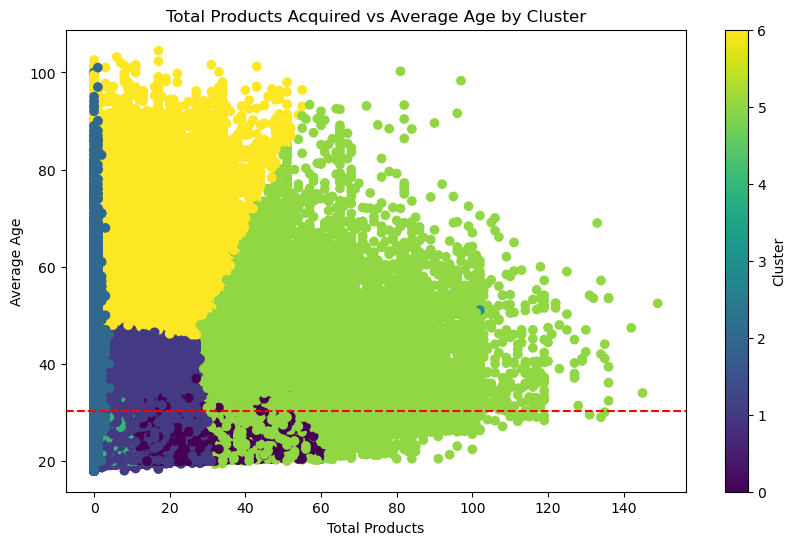

In [259]:
# Scatter Plot of the Relationship between Product Acquisition and Average Customer Age in Each Cluster
plt.figure(figsize=(10, 6))
plt.scatter(segmentation_df['total_products'], segmentation_df['average_age'], c=segmentation_df['cluster'])

plt.xlabel('Total Products')
plt.ylabel('Average Age')
plt.title('Total Products Acquired vs Average Age by Cluster')

plt.axhline(segmentation_df['average_age'].mean(), color='red', linestyle='--')
plt.colorbar(label='Cluster')

plt.show()


In the scatter plot, each cluster is represented by its own color, while the dashed red line represents the average age across all clusters (in the dataframe). This reference line allows us to compare the average age of customers in each cluster. By visualizing the position of the cluster points relative to this reference line, it may be quickly assess if the average age in a particular cluster is higher (obviously cluster 6, with all customers above it) or lower (Cluster 0, with most customers falling bellow the line) than the overall average age.

From the scatter plot, it can be inferred that there is no strong relationship between age and product acquisition. The distribution of data points across different ages suggests that the purchase of products from this company is independent of the age of the customers. This implies that customers of various age groups are equally likely to make purchases, and age alone may not be a significant factor in determining customer behavior in terms of product acquisition.

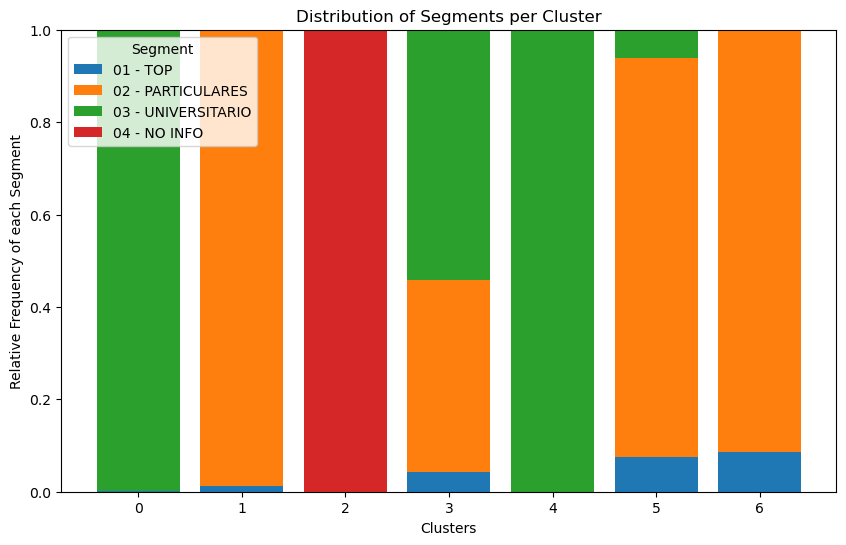

In [260]:
# Distribution of Segments per Cluster
cluster_segment_freq = pd.crosstab(segmentation_df['cluster'], segmentation_df['segment'], normalize='index')

# Plotting the stacked bar chart
plt.figure(figsize=(10, 6))
segments = cluster_segment_freq.columns
clusters = cluster_segment_freq.index
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']  

bottom = np.zeros(len(clusters))  # Valor inicial da base das barras

for i, segment in enumerate(segments):
    values = cluster_segment_freq[segment]
    plt.bar(clusters, values, bottom=bottom, label=segment, color=colors[i])
    bottom += values

plt.xlabel('Clusters')
plt.ylabel('Relative Frequency of each Segment')
plt.title('Distribution of Segments per Cluster')
plt.legend(title='Segment')

plt.show()


The stacked bar chart provides insights into the distribution of segments within each cluster, allowing us to understand the characteristics of customers in different segments. Further conclusions ahead. 

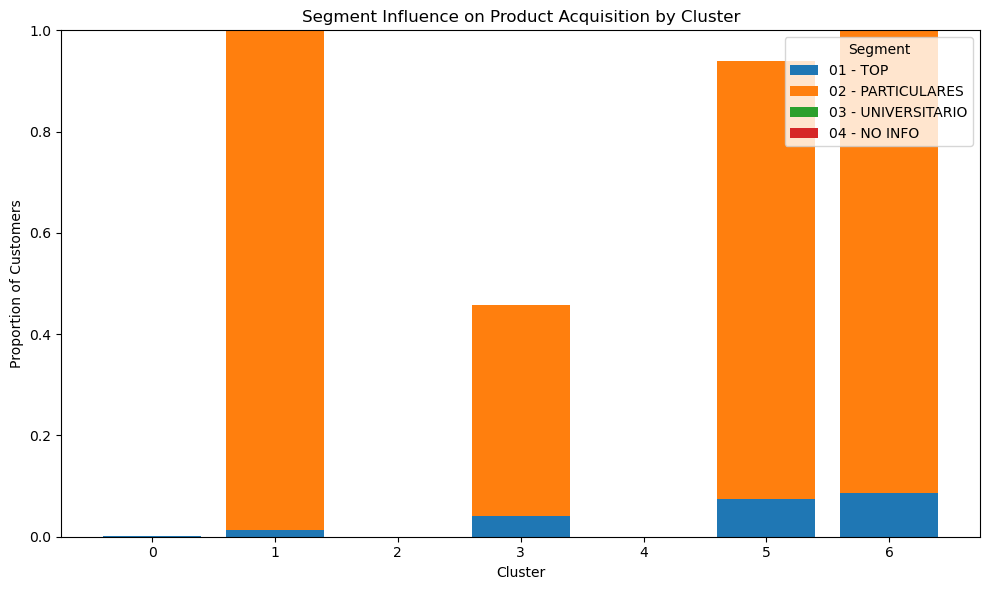

In [261]:

# Group the data by cluster and segment, and calculate the count of customers in each segment
segment_counts = segmentation_df.groupby(['cluster', 'segment']).size().unstack()

# Normalize the counts to represent the proportion of customers in each segment within each cluster
segment_proportions = segment_counts.div(segment_counts.sum(axis=1), axis=0)

# Get the unique segments
segments = segment_proportions.columns

# Set the cluster labels
clusters = segment_proportions.index

# Plot a stacked bar chart to visualize the segment influence on product acquisition for each cluster
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate the cumulative proportion for each segment
bottom = np.zeros(len(clusters))
for segment in segments:
    proportions = segment_proportions[segment].values
    ax.bar(clusters, proportions, bottom=bottom, label=segment)
    bottom += proportions

plt.xlabel('Cluster')
plt.ylabel('Proportion of Customers')
plt.title('Segment Influence on Product Acquisition by Cluster')

plt.legend(title='Segment', loc='upper right')
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()




 Let's dive deeper into each cluster:

Cluster 0 and Cluster 4 are exclusively composed of customers in the "UNIVERSITARIO" segment. These customers span a wide range of ages and salaries, indicating a diverse group with varying product preferences. They exhibit moderate product acquisition.

In Cluster 1 and Cluster 6, the majority of customers belong to the "PARTICULARES" segment, with a smaller proportion in the "TOP" segment. These customers have a wide age range, and their salaries vary. They tend to acquire a moderate number of products.

Cluster 2 comprises customers without segment information. These customers have lower salaries and typically acquire fewer products compared to other clusters. The age distribution in this cluster is more dispersed.

Cluster 3 stands out as a diverse cluster, with approximately 50% of customers in the "UNIVERSITARIO" segment, around 30% in the "PARTICULARES" segment, and the remaining portion in the "TOP" segment. These customers have the highest salaries (much above the average) compared to other clusters and demonstrate a reasonable product acquisition rate.

Cluster 5 is predominantly composed of customers in the "PARTICULARES" segment, with a smaller proportion in the "TOP" and "UNIVERSITARIO" segments. They exhibit a wide age range and have average salaries. Their product acquisition is the highest between the 7 clusters.

Lastly, Cluster 6 is characterized by customers in the "PARTICULARES" segment, with a larger proportion in the "TOP" segment compared to other clusters. The age range is similar to Cluster 5, but the salaries tend to be higher, however they do not acquire more products thaan cluster 5. These customers demonstrate moderate product acquisition.

By considering the segment distribution within each cluster and relating it to age, salaries, and product acquisition, we gain valuable insights for targeted marketing strategies. Understanding the preferences and characteristics of customers in each cluster allows for personalized and effective promotional campaigns tailored to their specific needs and interests.

# Recalling Merging Data Frames (df_final)

Let's delve deeper into analyzing the active customer behavior.

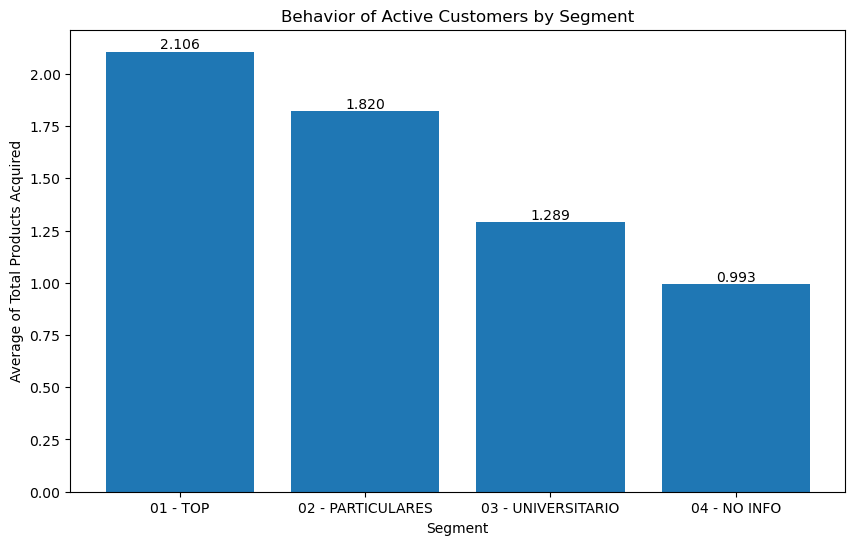

In [262]:
# Average Product Acquisition by Segment for Active Customers
active_customer_behavior = df_final[df_final['active_customer'] == 1].groupby('segment')['total_products'].mean()

# Plot the bar chart
plt.figure(figsize=(10, 6))

plt.bar(active_customer_behavior.index, active_customer_behavior.values)
for i, v in enumerate(active_customer_behavior.values):
    plt.text(i, v, f'{v:.3f}', ha='center', va='bottom')

plt.xlabel('Segment')
plt.ylabel('Average of Total Products Acquired')
plt.title('Behavior of Active Customers by Segment')

plt.show()



Based on the analysis of the bar chart, focusing on active customers and their respective segments, it is evident that customers classified as "TOP" have the highest average product acquisition, with a mean of 2.1 products. Following closely are customers categorized as "PARTICULARES" with an average of 1.8 products purchased. Customers in the "UNIVERSITARIOS" segment exhibit a lower average of 1.3 products acquired. On the other hand, customers with missing segment information have the lowest average product acquisition, standing at 1 product.

This finding indicates that among the active customers, those belonging to the "TOP" segment are the most likely to purchase a larger number of products. Therefore, to maximize product acquisition and sales, it would be beneficial to focus marketing efforts on targeting and appealing to customers in the "TOP" segment.

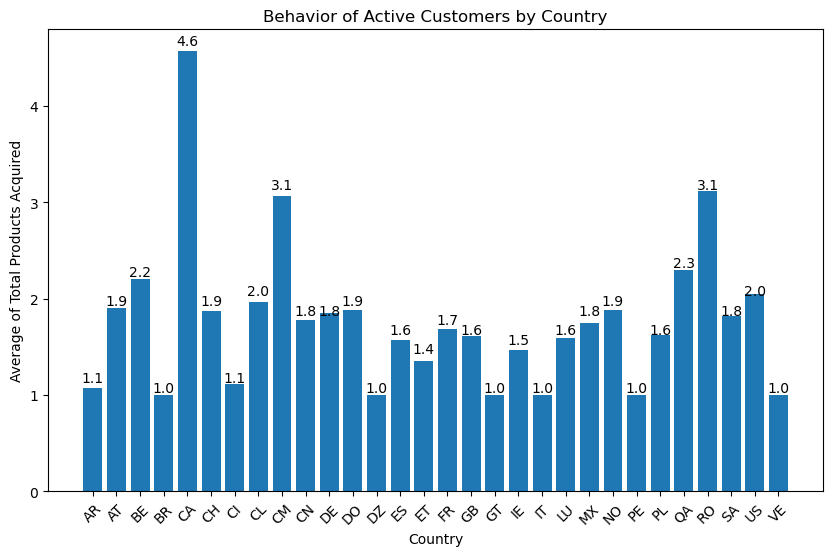

In [263]:
# Visualizing the Average Product Acquisition by Country for Active Customers
active_customer_behavior_country = df_final[df_final['active_customer'] == 1].groupby('country_id')['total_products'].mean()

# Creating the Bar plot
plt.figure(figsize=(10, 6))
plt.bar(active_customer_behavior_country.index, active_customer_behavior_country.values)
rounded_values = [round(value, 1) for value in active_customer_behavior_country.values]
for i, value in enumerate(rounded_values):
    plt.text(i, value, str(value), ha='center', va='bottom')

plt.xlabel('Country')
plt.ylabel('Average of Total Products Acquired')
plt.title('Behavior of Active Customers by Country')
plt.xticks(rotation=45)

plt.show()


Once again, focusing on active customers, we observe that customers from country Canada have the highest average product acquisition, followed by customers from Romania and Cameroon. This information provides valuable insights for targeting our marketing campaigns, as these countries show greater potential for product uptake.

It may be prudent to consider increasing the customer base from these countries to capitalize on the higher average product acquisition. Expanding our presence in Canada, Romania and Cameroon could potentially yield favorable results in terms of sales and customer engagement.

In [264]:
# Calculate purchase behavior metrics for countries
top_countries = df_final.groupby('country_id')['total_products'].sum().nlargest(5)

# Print the top countries with the highest purchase counts
print("Top Countries by Total Purchase:")
print(top_countries)


Top Countries by Total Purchase:
country_id
ES    6246163.0
GB        592.0
DE        347.0
FR        314.0
CH        281.0
Name: total_products, dtype: float64


In [265]:
# Calculate purchase behavior metrics for countries
top_countries_ave = df_final.groupby('country_id')['total_products'].mean().nlargest(5)

# Print the top countries with the highest purchase counts
print("Top Countries by Average Purchase:")
print(top_countries_ave)

Top Countries by Average Purchase:
country_id
CA    3.318182
RO    3.111111
CM    3.058824
QA    2.294118
CL    1.966667
Name: total_products, dtype: float64


The dataset predominantly consists of customers from Spain, but they do not have the highest purchase percentage. Actually, customers from Canada have the highest average purchase rate. Despite the large number of customers from Spain, it might be strategic to focus our marketing campaigns on this country to maximize our potential reach and engagement. However, it is worth considering targeting customers from Romania and Cameroon as well, given their significantly higher average purchase rates. Expanding our efforts in these countries could lead to increased sales and customer satisfaction.

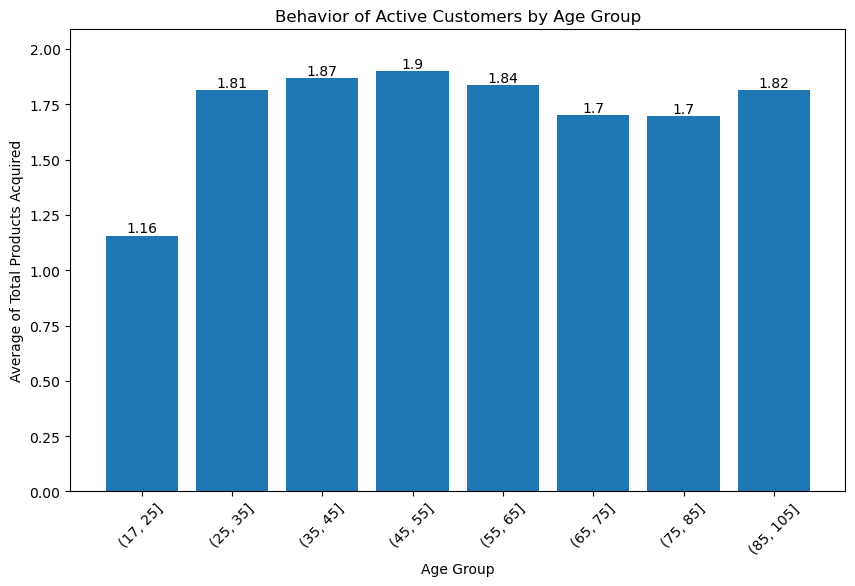

In [266]:
#Analyze the behavior of active customers in relation to the products they possess per age group
active_customer_behavior_age = df_final[df_final['active_customer'] == 1].groupby('age_group')['total_products'].mean()

#Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(active_customer_behavior_age.index.astype(str), active_customer_behavior_age.values)

plt.xlabel('Age Group')
plt.ylabel('Average of Total Products Acquired')
plt.title('Behavior of Active Customers by Age Group')
plt.xticks(rotation=45)
plt.ylim(0, max(active_customer_behavior_age.values) * 1.1)

for i, v in enumerate(active_customer_behavior_age.values):
    plt.text(i, v, str(round(v, 2)), ha='center', va='bottom')

plt.show()

From the bar chart, we can observe the behavior of active customers in relation to the average number of products they possess in each age group.

Based on the chart, we can identify the age groups that have a higher average number of products acquired (between 46-55) and those with a lower average (18-25), which aligns with our expectations. Interestingly, after the age of 26, there is not a significant variation in the average number of products acquired with age. This suggests that age might not be a strong determining factor for product acquisition in this particular dataset.

In [267]:
# Calculate purchase behavior metrics for countries
top_countries_ave = df_final.groupby('age_group')['total_products'].mean().nlargest(8)

# Print the top countries with the highest purchase counts
print("Top Age Groups by Average Purchase:")
print(round(top_countries_ave, 3))

Top Age Groups by Average Purchase:
age_group
(45, 55]     1.392
(35, 45]     1.348
(55, 65]     1.348
(85, 105]    1.303
(75, 85]     1.258
(65, 75]     1.237
(25, 35]     1.197
(17, 25]     0.874
Name: total_products, dtype: float64


Based on the analysis of average purchase behavior by age group, we can observe that customers in the age groups of 46-55, 36-45, and 56-65 tend to have the highest average purchase counts. This suggests that these age groups are more likely to acquire a larger number of products compared to other age groups. On the other hand, the age groups of 18-25 and 26-35 have slightly lower average purchase counts.

However, it is important to note that the average purchase behavior does not show a significant variation across different age groups, except for the younger age groups of 18-25 and 26-35. This indicates that age may not be the sole determining factor in customers' product acquisition behavior. Other factors such as individual preferences, lifestyle, and needs may also play a significant role.

Therefore, while age can provide some insights into customers' purchasing patterns, it is essential to consider a more comprehensive approach that takes into account various demographic and behavioral factors to develop effective targeted marketing strategies.

In [268]:
# Mean of total products aquired according to gender
gender_ave = df_final.groupby('gender')['total_products'].mean()
print("Average Purchase of Products according to gender:")
print(round(gender_ave, 3))

Average Purchase of Products according to gender:
gender
H    1.022
V    1.091
Name: total_products, dtype: float64


Based on the analysis of the mean total products acquired by gender, we can observe that male customers (V) have a slightly higher average of total products acquired (1.091) compared to female customers (H) who have an average of 1.022.

However, it is important to note that the difference in the average total products acquired between genders is relatively small. This suggests that gender alone may not be a significant factor in determining customers' product acquisition behavior.

In [269]:
# Information about categorical variables in df_final
df_final.select_dtypes(include=['object']).describe().T

count unique                 top       freq
segment        5920664      4  03 - UNIVERSITARIO    3973938
country_id     5920664     41                  ES    5918429
region_code  5920664.0   53.0                28.0  1163553.0
gender         5920664      2                   H    3066813
deceased       5920664      2                   N    5919589

# Machine Learning


In the context of Machine Learning, we will be developing three different models based on Erin's request. Considering that our revenue is approximately €10 for each account sold, €40 for savings and investment products (such as plans and funds), and €60 for financing products (including loans and cards), we have allocated a budget for 10,000 promotional emails.

To achieve this, we will utilize the Random Forest Classifier, a powerful classification model known for its accuracy and robustness. We will begin by performing one-hot encoding on the categorical variables 'segment' and 'country_id'. Furthermore, we will exclude the 'age_group' and 'gender' variables, as they have shown minimal impact on product acquisition.

The primary objective of these models is to identify the 10,000 customers who are most likely to spend more money with us by acquiring a higher number of products or more expensive ones. By targeting these customers specifically, we can optimize our marketing efforts and increase the chances of generating significant sales and revenue.


**Machine Learning for account sold (10€)**

In [270]:
# Relevant categorical variables
cat_var = df_final[['segment', 'country_id']]

# One-hot encoding of categorical variables
df_cat_var = pd.get_dummies(cat_var)

df_cat_var

segment_01 - TOP  segment_02 - PARTICULARES  \
0                       0                          1   
1                       0                          0   
2                       0                          0   
3                       0                          0   
4                       0                          0   
...                   ...                        ...   
5920659                 0                          0   
5920660                 0                          0   
5920661                 0                          1   
5920662                 0                          0   
5920663                 0                          0   

         segment_03 - UNIVERSITARIO  segment_04 - NO INFO  country_id_AR  \
0                                 0                     0              0   
1                                 1                     0              0   
2                                 1                     0              0   
3                                 1                     0              0   
4                                 1                     0              0   
...                             ...                   ...            ...   
5920659                           1                     0              0   
5920660                           1                     0              0   
5920661                           0                     0              0   
5920662                           1                     0              0   
5920663                           0                     1              0   

         country_id_AT  country_id_BE  country_id_BR  country_id_CA  \
0                    0              0              0              0   
1                    0              0              0              0   
2                    0              0              0              0   
3                    0              0              0              0   
4                    0              0              0              0   
...                ...            ...            ...            ...   
5920659              0              0              0              0   
5920660              0              0              0              0   
5920661              0              0              0              0   
5920662              0              0              0              0   
5920663              0              0              0              0   

         country_id_CH  ...  country_id_PL  country_id_PT  country_id_QA  \
0                    0  ...              0              0              0   
1                    0  ...              0              0              0   
2                    0  ...              0              0              0   
3                    0  ...              0              0              0   
4                    0  ...              0              0              0   
...                ...  ...            ...            ...            ...   
5920659              0  ...              0              0              0   
5920660              0  ...              0              0              0   
5920661              0  ...              0              0              0   
5920662              0  ...              0              0              0   
5920663              0  ...              0              0              0   

         country_id_RO  country_id_RU  country_id_SA  country_id_SE  \
0                    0              0              0              0   
1                    0              0              0              0   
2                    0              0              0              0   
3                    0              0              0              0   
4                    0              0              0              0   
...                ...            ...            ...            ...   
5920659              0              0              0              0   
5920660              0              0              0              0   
5920661           

In [271]:
df_ML = pd.concat([df_final, df_cat_var], axis=1)
df_ML

pk_cid pk_partition  active_customer             segment  \
0        1375586   2018-01-28                1   02 - PARTICULARES   
1        1050611   2018-01-28                0  03 - UNIVERSITARIO   
2        1050612   2018-01-28                0  03 - UNIVERSITARIO   
3        1050613   2018-01-28                0  03 - UNIVERSITARIO   
4        1050614   2018-01-28                1  03 - UNIVERSITARIO   
...          ...          ...              ...                 ...   
5920659  1166765   2019-05-28                0  03 - UNIVERSITARIO   
5920660  1166764   2019-05-28                0  03 - UNIVERSITARIO   
5920661  1166763   2019-05-28                1   02 - PARTICULARES   
5920662  1166789   2019-05-28                0  03 - UNIVERSITARIO   
5920663  1550586   2019-05-28                1        04 - NO INFO   

         short_term_deposit  loans  mortgage  funds  securities  \
0                         0      0         0      0           0   
1                         0      0         0      0           0   
2                         0      0         0      0           0   
3                         1      0         0      0           0   
4                         0      0         0      0           0   
...                     ...    ...       ...    ...         ...   
5920659                   0      0         0      0           0   
5920660                   0      0         0      0           0   
5920661                   0      0         0      0           0   
5920662                   0      0         0      0           0   
5920663                   0      0         0      0           0   

         long_term_deposit  ...  country_id_PL  country_id_PT  country_id_QA  \
0                        0  ...              0              0              0   
1                        0  ...              0              0              0   
2                        0  ...              0              0              0   
3                        0  ...              0              0              0   
4                        0  ...              0              0              0   
...                    ...  ...            ...            ...            ...   
5920659                  0  ...              0              0              0   
5920660                  0  ...              0              0              0   
5920661                  0  ...              0              0              0   
5920662                  0  ...              0              0              0   
5920663                  0  ...              0              0              0   

         country_id_RO  country_id_RU  country_id_SA  country_id_SE  \
0                    0              0              0              0   
1                    0              0              0              0   
2                    0              0              0              0   
3                    0              0              0              0   
4                    0              0              0              0   
...                ...            ...            ...            ...   
5920659              0              0              0              0   
5920660              0              0              0              0   
5920661              0              0              0              0   
5920662              0              0              0              0   
5920663              0              0              0              0   

         country_id_SN  country_id_US  country_id_VE  
0                    0              0              0  
1                    0              0              0  
2                    0              0              0  
3                    0              0              0  
4                    0              0              0  
...                ...            ...            ...  
5920659              0              0              0  
5920660              0              0              0  
5920661              0              0              0  



To make an informed decision on which partitions to designate as the test set for the problem, let's analyze the count of partitions per year.

In [272]:
df_ML.drop(['segment','country_id', 'region_code', 'gender', 'deceased', 'age_group'],
           axis=1,
           inplace=True
          )

In [273]:
df_ML['Year'] = df_ML['year_month'].dt.year
df_ML['Month'] = df_ML['year_month'].dt.month


df_ML['Year'].value_counts()

2018    3761238
2019    2159426
Name: Year, dtype: int64

Taking into account Erin's email: the revenue per account sold is €10, €40 for savings and investment products (such as plans and funds), and €60 for financing products (including loans and cards).

Now, before proceeding with the creation of three machine learning models, each dedicated to a specific type of product, we need to map each product to its corresponding category. This step will help us organize and analyze the data more effectively.

In [274]:
# Mapping products to their corresponding revenue type
mapped_columns = {
    'em_account_p': 'Account_Sold',
    'em_account_pp': 'Account_Sold',
    'em_acount': 'Account_Sold',
    'emc_account': 'Account_Sold',
    'long_term_deposit': 'Savings_Investments',
    'short_term_deposit': 'Savings_Investments',
    'loans': 'Financing_Products',
    'mortgage': 'Financing_Products',
    'credit_card': 'Financing_Products'
}

mapped_df = df_ML[['pk_cid', 'pk_partition', 'active_customer', 'total_products', 'salary','age']].copy()

# Summing the number of products for each revenue type per client
mapped_df['Account_Sold'] = df_ML[['em_account_p', 'em_account_pp', 'em_acount', 'emc_account']].sum(axis=1)
mapped_df['Savings_Investments'] = df_ML[['long_term_deposit', 'short_term_deposit']].sum(axis=1)
mapped_df['Financing_Products'] = df_ML[['loans', 'mortgage', 'credit_card']].sum(axis=1)

mapped_df['Account_Sold'] = mapped_df['Account_Sold'] > 0
mapped_df['Savings_Investments'] = mapped_df['Savings_Investments'] > 0
mapped_df['Financing_Products'] = mapped_df['Financing_Products'] > 0

mapped_df

pk_cid pk_partition  active_customer  total_products     salary  \
0        1375586   2018-01-28                1             1.0   87218.10   
1        1050611   2018-01-28                0             1.0   35548.74   
2        1050612   2018-01-28                0             1.0  122179.11   
3        1050613   2018-01-28                0             1.0  119775.54   
4        1050614   2018-01-28                1             1.0   88654.65   
...          ...          ...              ...             ...        ...   
5920659  1166765   2019-05-28                0             1.0   43912.17   
5920660  1166764   2019-05-28                0             1.0   23334.99   
5920661  1166763   2019-05-28                1             1.0   88654.65   
5920662  1166789   2019-05-28                0             1.0  199592.82   
5920663  1550586   2019-05-28                1             1.0   88654.65   

         age  Account_Sold  Savings_Investments  Financing_Products  
0         35          True                False               False  
1         23          True                False               False  
2         23          True                False               False  
3         22         False                 True               False  
4         23          True                False               False  
...      ...           ...                  ...                 ...  
5920659   22          True                False               False  
5920660   23          True                False               False  
5920661   47          True                False               False  
5920662   22          True                False               False  
5920663   37          True                False               False  

[5920664 rows x 9 columns]

In [275]:
# Analyzing the Distribution of Rows per Year
mapped_df['year_month'] = mapped_df['pk_partition'].dt.to_period('M')
mapped_df['Year'] = mapped_df['year_month'].dt.year
mapped_df['Month'] = mapped_df['year_month'].dt.month

print('Number of entries for:')
print(mapped_df['Year'].value_counts())

Number of entries for:
2018    3761238
2019    2159426
Name: Year, dtype: int64


In [276]:
# To Clearly see how the new variables and total_products behave during each month
df = mapped_df.pivot_table(index=['Year', 'Month'], values =['total_products','Account_Sold', 'Savings_Investments',	'Financing_Products'], aggfunc=[sum, np.mean])
df

sum                                                        \
           Account_Sold Financing_Products Savings_Investments total_products   
Year Month                                                                      
2018 1           222304               3335                5744       296456.0   
     2           224426               3293                6272       302296.0   
     3           226329               3528                6601       308725.0   
     4           227803               3743                6812       313339.0   
     5           229666               3819                6782       316261.0   
     6           232658               4021                6798       322125.0   
     7           242732               4158                7033       336992.0   
     8           254482               4222                7217       348847.0   
     9           269845               4306                7498       369005.0   
     10          286483               4404                7713       391167.0   
     11          294028               4528                7427       402654.0   
     12          298157               4551                7241       411973.0   
2019 1           301456               4509                6772       411136.0   
     2           303127               4557                6663       421247.0   
     3           304736               4589                6533       427595.0   
     4           306039               4765                6364       431612.0   
     5           307196               4818                6125       437630.0   

                   mean                                                        
           Account_Sold Financing_Products Savings_Investments total_products  
Year Month                                                                     
2018 1         0.934537           0.014020            0.024147       1.246263  
     2         0.931750           0.013672            0.026039       1.255043  
     3         0.929254           0.014485            0.027102       1.267552  
     4         0.927099           0.015233            0.027723       1.275208  
     5         0.925610           0.015391            0.027333       1.274609  
     6         0.929654           0.016067            0.027163       1.287146  
     7         0.719961           0.012333            0.020860       0.999543  
     8         0.725646           0.012039            0.020579       0.994725  
     9         0.723377           0.011543            0.020100       0.989197  
     10        0.716258           0.011011            0.019284       0.977986  
     11        0.710211           0.010937            0.017940       0.972592  
     12        0.709926           0.010836            0.017241       0.980928  
2019 1         0.710457           0.010627            0.015960       0.968945  
     2         0.707753           0.010640            0.015557       0.983544  
     3         0.705114           0.010618            0.015116       0.989391  
     4         0.702498           0.010938            0.014608       0.990745  
     5         0.699773           0.010975            0.013952       0.996893


Upon analyzing the pivot table, it is clear that the majority of product acquisitions are related to the Account Sold, which is priced at €10. This indicates that customers are acquiring a larger quantity of lower-priced products. The number of acquisitions has been steadily increasing over time, suggesting a growing interest in these products.

However, it is important to note that the mean value of these acquisitions is decreasing. This could indicate that customers are not only purchasing more products but also opting for higher-priced options.

In contrast, financing products have a lower acquisition rate compared to Account Sold. Thus, there is an increasing trend in the mean value of these acquisitions over time. This suggests that customers, while purchasing fewer financing products overall, are gravitating towards higher-value options.

Overall, these observations highlight a combination of increased product acquisitions, a preference for lower-priced options as Account Sold category, and a growing interest in higher-value products within the Financing category.

# **Machine Learning for Account Sold**

In [277]:
# Creating DF
df_acc_sold = mapped_df[['pk_partition','pk_cid','active_customer','total_products', 'salary', 'age', 'Account_Sold']].copy()
df_acc_sold = pd.concat([df_acc_sold, df_cat_var], axis=1)

df_acc_sold

pk_partition   pk_cid  active_customer  total_products     salary  \
0         2018-01-28  1375586                1             1.0   87218.10   
1         2018-01-28  1050611                0             1.0   35548.74   
2         2018-01-28  1050612                0             1.0  122179.11   
3         2018-01-28  1050613                0             1.0  119775.54   
4         2018-01-28  1050614                1             1.0   88654.65   
...              ...      ...              ...             ...        ...   
5920659   2019-05-28  1166765                0             1.0   43912.17   
5920660   2019-05-28  1166764                0             1.0   23334.99   
5920661   2019-05-28  1166763                1             1.0   88654.65   
5920662   2019-05-28  1166789                0             1.0  199592.82   
5920663   2019-05-28  1550586                1             1.0   88654.65   

         age  Account_Sold  segment_01 - TOP  segment_02 - PARTICULARES  \
0         35          True                 0                          1   
1         23          True                 0                          0   
2         23          True                 0                          0   
3         22         False                 0                          0   
4         23          True                 0                          0   
...      ...           ...               ...                        ...   
5920659   22          True                 0                          0   
5920660   23          True                 0                          0   
5920661   47          True                 0                          1   
5920662   22          True                 0                          0   
5920663   37          True                 0                          0   

         segment_03 - UNIVERSITARIO  ...  country_id_PL  country_id_PT  \
0                                 0  ...              0              0   
1                                 1  ...              0              0   
2                                 1  ...              0              0   
3                                 1  ...              0              0   
4                                 1  ...              0              0   
...                             ...  ...            ...            ...   
5920659                           1  ...              0              0   
5920660                           1  ...              0              0   
5920661                           0  ...              0              0   
5920662                           1  ...              0              0   
5920663                           0  ...              0              0   

         country_id_QA  country_id_RO  country_id_RU  country_id_SA  \
0                    0              0              0              0   
1                    0              0              0              0   
2                    0              0              0              0   
3                    0              0              0              0   
4                    0              0              0              0   
...                ...            ...            ...            ...   
5920659              0              0              0              0   
5920660              0              0              0              0   
5920661              0              0              0              0   
5920662              0              0              0              0   
5920663              0              0              0              0   

         country_id_SE  country_id_SN  country_id_US  country_id_VE  
0                    0              0              0              0  
1                    0              0              0              0  
2                    0              0              0              0  
3                    0              0              0              0  
4                    0              0              0              0  
...                .

To begin with, it is necessary to **sort the aforementioned DataFrame in ascending order** based on 'pk_cid' and 'pk_partition' in order to prioritize customer sorting followed by date sorting. This sorting arrangement will enable the subsequent shift operation to be performed for Account_sold.

In [278]:
# Sorting my DF ccorfing to pk_cid and pk_partition variables
df_acc_sold = df_acc_sold.sort_values(['pk_cid', 'pk_partition'], ascending=[True, True])
df_acc_sold

pk_partition   pk_cid  active_customer  total_products    salary  age  \
1469193   2018-07-28    15891                1             1.0  88654.65   59   
2153344   2018-08-28    15891                0             0.0  88654.65   59   
2943551   2018-11-28    16063                1             0.0  88654.65   62   
3604761   2018-12-28    16063                1             0.0  88654.65   62   
4002815   2019-01-28    16063                1             0.0  88654.65   62   
...              ...      ...              ...             ...       ...  ...   
5639601   2019-05-28  1553685                0             0.0  88654.65   52   
5639600   2019-05-28  1553686                0             0.0  88654.65   30   
5639599   2019-05-28  1553687                0             0.0  88654.65   21   
5639598   2019-05-28  1553688                0             0.0  88654.65   43   
5639597   2019-05-28  1553689                0             0.0  88654.65   40   

         Account_Sold  segment_01 - TOP  segment_02 - PARTICULARES  \
1469193          True                 0                          1   
2153344         False                 0                          1   
2943551         False                 0                          1   
3604761         False                 0                          1   
4002815         False                 0                          1   
...               ...               ...                        ...   
5639601         False                 0                          0   
5639600         False                 0                          0   
5639599         False                 0                          0   
5639598         False                 0                          0   
5639597         False                 0                          0   

         segment_03 - UNIVERSITARIO  ...  country_id_PL  country_id_PT  \
1469193                           0  ...              0              0   
2153344                           0  ...              0              0   
2943551                           0  ...              0              0   
3604761                           0  ...              0              0   
4002815                           0  ...              0              0   
...                             ...  ...            ...            ...   
5639601                           0  ...              0              0   
5639600                           0  ...              0              0   
5639599                           0  ...              0              0   
5639598                           0  ...              0              0   
5639597                           0  ...              0              0   

         country_id_QA  country_id_RO  country_id_RU  country_id_SA  \
1469193              0              0              0              0   
2153344              0              0              0              0   
2943551              0              0              0              0   
3604761              0              0              0              0   
4002815              0              0              0              0   
...                ...            ...            ...            ...   
5639601              0              0              0              0   
5639600              0              0              0              0   
5639599              0              0              0              0   
5639598              0              0              0              0   
5639597              0              0              0              0   

         country_id_SE  country_id_SN  country_id_US  country_id_VE  
1469193              0              0              0              0  
2153344              0              0              0              0  
2943551              0              0              0              0  
3604761              0              0              0              0  
4002815              0              0              0              0  
...                ...          

**Analysis customer purchasing behaviour for Account Sold products over time.**

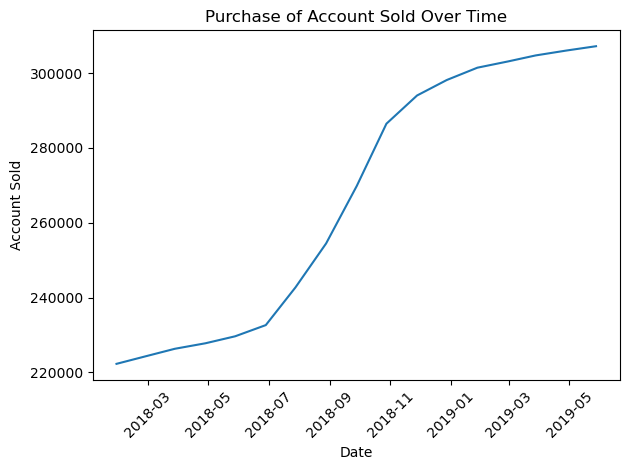

In [279]:
# Creating a copy df
df_acc_sold_1 = df_acc_sold.copy()

# Set pk_partition (date), as index
df_acc_sold_1.set_index('pk_partition', inplace=True)

# Group by Date and sum all Account Sold for each month
df_acc_sold_1['Date'] = df_acc_sold_1.index.date
df_acc_sold_1 = df_acc_sold_1.groupby('Date')['Account_Sold'].sum().reset_index()

# Line Plot
plt.plot(df_acc_sold_1['Date'], df_acc_sold_1['Account_Sold'])
plt.xlabel('Date')
plt.ylabel('Account Sold')
plt.title('Purchase of Account Sold Over Time')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

As has already been said, the number of accounts sold increases over time.

In [280]:
top_cost_acc = df_acc_sold.groupby('pk_cid')['Account_Sold'].sum().nlargest(15)
print("Top Customers that Purchase Products from Account Sold:")
print(top_cost_acc)

Top Customers that Purchase Products from Account Sold:
pk_cid
17457    17
17799    17
17970    17
18704    17
19268    17
19684    17
20333    17
20417    17
21551    17
22212    17
25036    17
25054    17
25398    17
26018    17
26163    17
Name: Account_Sold, dtype: int64


In [281]:
# Calculate purchase behavior metrics for countries
top_act_cost_acc = df_acc_sold.groupby('active_customer')['Account_Sold'].mean()

# Print the top countries with the highest purchase counts
print("Average Account Sold Purchased by Active and Inactive Customers:")
print(top_act_cost_acc)

Average Account Sold Purchased by Active and Inactive Customers:
active_customer
0    0.699842
1    0.863388
Name: Account_Sold, dtype: float64


**Shifting Account Sold**

Including a shift column for the target variable is crucial in ML. This column will encompass the values to be predicted, such as customers' purchases for the next month, utilizing the available information. By introducing a time shift, the ML model can be trained to forecast future sales values accurately

In [282]:
# Shifting a montth for each customer, so that the last month is the predious values for every customer
df_acc_sold['previous_value'] = df_acc_sold.groupby(['pk_cid'])['Account_Sold'].shift(-1)
df_acc_sold

pk_partition   pk_cid  active_customer  total_products    salary  age  \
1469193   2018-07-28    15891                1             1.0  88654.65   59   
2153344   2018-08-28    15891                0             0.0  88654.65   59   
2943551   2018-11-28    16063                1             0.0  88654.65   62   
3604761   2018-12-28    16063                1             0.0  88654.65   62   
4002815   2019-01-28    16063                1             0.0  88654.65   62   
...              ...      ...              ...             ...       ...  ...   
5639601   2019-05-28  1553685                0             0.0  88654.65   52   
5639600   2019-05-28  1553686                0             0.0  88654.65   30   
5639599   2019-05-28  1553687                0             0.0  88654.65   21   
5639598   2019-05-28  1553688                0             0.0  88654.65   43   
5639597   2019-05-28  1553689                0             0.0  88654.65   40   

         Account_Sold  segment_01 - TOP  segment_02 - PARTICULARES  \
1469193          True                 0                          1   
2153344         False                 0                          1   
2943551         False                 0                          1   
3604761         False                 0                          1   
4002815         False                 0                          1   
...               ...               ...                        ...   
5639601         False                 0                          0   
5639600         False                 0                          0   
5639599         False                 0                          0   
5639598         False                 0                          0   
5639597         False                 0                          0   

         segment_03 - UNIVERSITARIO  ...  country_id_PT  country_id_QA  \
1469193                           0  ...              0              0   
2153344                           0  ...              0              0   
2943551                           0  ...              0              0   
3604761                           0  ...              0              0   
4002815                           0  ...              0              0   
...                             ...  ...            ...            ...   
5639601                           0  ...              0              0   
5639600                           0  ...              0              0   
5639599                           0  ...              0              0   
5639598                           0  ...              0              0   
5639597                           0  ...              0              0   

         country_id_RO  country_id_RU  country_id_SA  country_id_SE  \
1469193              0              0              0              0   
2153344              0              0              0              0   
2943551              0              0              0              0   
3604761              0              0              0              0   
4002815              0              0              0              0   
...                ...            ...            ...            ...   
5639601              0              0              0              0   
5639600              0              0              0              0   
5639599              0              0              0              0   
5639598              0              0              0              0   
5639597              0              0              0              0   

         country_id_SN  country_id_US  country_id_VE  previous_value  
1469193              0              0              0           False  
2153344              0              0              0             NaN  
2943551              0              0              0           False  
3604761              0              0              0           False  
4002815              0              0              0           False  
...                ...    

In [283]:
# this should be equivelent to the numeber of total customers
df_acc_sold['previous_value'].isnull().sum()

452197

In [284]:
# Discovering how many entries this df has each year (2018 and 2019)
df_acc_sold['Year'] = df_acc_sold['pk_partition'].dt.year
df_acc_sold['Month'] = df_acc_sold['pk_partition'].dt.month


df_acc_sold['Year'].value_counts()

2018    3761238
2019    2159426
Name: Year, dtype: int64

**Separating Development and Validation sets:**

Development set will have all entries/rows of the dataframe except the last two months (April and May 2019)

Validation set will only have the entries/rows that belong to April 2019

Test set will have the entries/rows belongging to May 2019

In [285]:
# Creating Development (Training), Validation, and Test set
train_df = df_acc_sold[((df_acc_sold['Year'] == 2018) | ((df_acc_sold['Year'] == 2019) & (df_acc_sold['Month'] < 4)))]
val_df = df_acc_sold[(df_acc_sold['Year'] == 2019) & (df_acc_sold['Month'] == 4)]
test_df = df_acc_sold[(df_acc_sold['Year'] == 2019) & (df_acc_sold['Month'] == 5)]

In [286]:
train_df.drop(['Year','Month'], axis=1, inplace=True)
train_df

/var/folders/gx/5k88wzkx0zv8bsfz2nt93d0h0000gn/T/ipykernel_777/3446173827.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



pk_partition   pk_cid  active_customer  total_products    salary  age  \
1469193   2018-07-28    15891                1             1.0  88654.65   59   
2153344   2018-08-28    15891                0             0.0  88654.65   59   
2943551   2018-11-28    16063                1             0.0  88654.65   62   
3604761   2018-12-28    16063                1             0.0  88654.65   62   
4002815   2019-01-28    16063                1             0.0  88654.65   62   
...              ...      ...              ...             ...       ...  ...   
4845206   2019-03-28  1542658                0             0.0  88654.65   33   
4845205   2019-03-28  1542659                0             0.0  88654.65   33   
4845204   2019-03-28  1542660                0             0.0  88654.65   35   
4845203   2019-03-28  1542661                0             0.0  88654.65   34   
4845202   2019-03-28  1542662                0             0.0  88654.65   39   

         Account_Sold  segment_01 - TOP  segment_02 - PARTICULARES  \
1469193          True                 0                          1   
2153344         False                 0                          1   
2943551         False                 0                          1   
3604761         False                 0                          1   
4002815         False                 0                          1   
...               ...               ...                        ...   
4845206         False                 0                          1   
4845205         False                 0                          1   
4845204         False                 0                          1   
4845203         False                 0                          1   
4845202         False                 0                          1   

         segment_03 - UNIVERSITARIO  ...  country_id_PT  country_id_QA  \
1469193                           0  ...              0              0   
2153344                           0  ...              0              0   
2943551                           0  ...              0              0   
3604761                           0  ...              0              0   
4002815                           0  ...              0              0   
...                             ...  ...            ...            ...   
4845206                           0  ...              0              0   
4845205                           0  ...              0              0   
4845204                           0  ...              0              0   
4845203                           0  ...              0              0   
4845202                           0  ...              0              0   

         country_id_RO  country_id_RU  country_id_SA  country_id_SE  \
1469193              0              0              0              0   
2153344              0              0              0              0   
2943551              0              0              0              0   
3604761              0              0              0              0   
4002815              0              0              0              0   
...                ...            ...            ...            ...   
4845206              0              0              0              0   
4845205              0              0              0              0   
4845204              0              0              0              0   
4845203              0              0              0              0   
4845202              0              0              0              0   

         country_id_SN  country_id_US  country_id_VE  previous_value  
1469193              0              0              0           False  
2153344              0              0              0             NaN  
2943551              0              0              0           False  
3604761              0              0              0           False  
4002815              0              0              0           False  
...                ...    

In [287]:
train_df['previous_value'].isnull().sum()

12021

In [288]:
train_df.dropna(inplace=True)

/var/folders/gx/5k88wzkx0zv8bsfz2nt93d0h0000gn/T/ipykernel_777/519058362.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [289]:
# Percentage of information in Development set
print(train_df.shape)
print(train_df.shape[0]/df_acc_sold.shape[0])

(5034005, 53)
0.8502433173035997


In [290]:
val_df['previous_value'].isnull().sum()

1182

In [291]:
# Percentage of information in Validation set
print(val_df.shape)
print(val_df.shape[0]/df_acc_sold.shape[0])

(435644, 55)
0.07358026059239302


In [292]:
val_df.dropna(inplace=True)

/var/folders/gx/5k88wzkx0zv8bsfz2nt93d0h0000gn/T/ipykernel_777/3017562600.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [293]:
test_df['previous_value'].isnull().sum()

438994

In [294]:
# Percentage of information in Validation set
print(test_df.shape)
print(test_df.shape[0]/df_acc_sold.shape[0])

(438994, 55)
0.0741460755077471


**Training the Model**

In [295]:
train_df

pk_partition   pk_cid  active_customer  total_products    salary  age  \
1469193   2018-07-28    15891                1             1.0  88654.65   59   
2943551   2018-11-28    16063                1             0.0  88654.65   62   
3604761   2018-12-28    16063                1             0.0  88654.65   62   
4002815   2019-01-28    16063                1             0.0  88654.65   62   
4451602   2019-02-28    16063                1             0.0  88654.65   62   
...              ...      ...              ...             ...       ...  ...   
4845206   2019-03-28  1542658                0             0.0  88654.65   33   
4845205   2019-03-28  1542659                0             0.0  88654.65   33   
4845204   2019-03-28  1542660                0             0.0  88654.65   35   
4845203   2019-03-28  1542661                0             0.0  88654.65   34   
4845202   2019-03-28  1542662                0             0.0  88654.65   39   

         Account_Sold  segment_01 - TOP  segment_02 - PARTICULARES  \
1469193          True                 0                          1   
2943551         False                 0                          1   
3604761         False                 0                          1   
4002815         False                 0                          1   
4451602         False                 0                          1   
...               ...               ...                        ...   
4845206         False                 0                          1   
4845205         False                 0                          1   
4845204         False                 0                          1   
4845203         False                 0                          1   
4845202         False                 0                          1   

         segment_03 - UNIVERSITARIO  ...  country_id_PT  country_id_QA  \
1469193                           0  ...              0              0   
2943551                           0  ...              0              0   
3604761                           0  ...              0              0   
4002815                           0  ...              0              0   
4451602                           0  ...              0              0   
...                             ...  ...            ...            ...   
4845206                           0  ...              0              0   
4845205                           0  ...              0              0   
4845204                           0  ...              0              0   
4845203                           0  ...              0              0   
4845202                           0  ...              0              0   

         country_id_RO  country_id_RU  country_id_SA  country_id_SE  \
1469193              0              0              0              0   
2943551              0              0              0              0   
3604761              0              0              0              0   
4002815              0              0              0              0   
4451602              0              0              0              0   
...                ...            ...            ...            ...   
4845206              0              0              0              0   
4845205              0              0              0              0   
4845204              0              0              0              0   
4845203              0              0              0              0   
4845202              0              0              0              0   

         country_id_SN  country_id_US  country_id_VE  previous_value  
1469193              0              0              0           False  
2943551              0              0              0           False  
3604761              0              0              0           False  
4002815              0              0              0           False  
4451602              0              0              0           False  
...                ...    

In [296]:
selected_columns = train_df.iloc[:, 3:-1]
selected_columns

total_products    salary  age  Account_Sold  segment_01 - TOP  \
1469193             1.0  88654.65   59          True                 0   
2943551             0.0  88654.65   62         False                 0   
3604761             0.0  88654.65   62         False                 0   
4002815             0.0  88654.65   62         False                 0   
4451602             0.0  88654.65   62         False                 0   
...                 ...       ...  ...           ...               ...   
4845206             0.0  88654.65   33         False                 0   
4845205             0.0  88654.65   33         False                 0   
4845204             0.0  88654.65   35         False                 0   
4845203             0.0  88654.65   34         False                 0   
4845202             0.0  88654.65   39         False                 0   

         segment_02 - PARTICULARES  segment_03 - UNIVERSITARIO  \
1469193                          1                           0   
2943551                          1                           0   
3604761                          1                           0   
4002815                          1                           0   
4451602                          1                           0   
...                            ...                         ...   
4845206                          1                           0   
4845205                          1                           0   
4845204                          1                           0   
4845203                          1                           0   
4845202                          1                           0   

         segment_04 - NO INFO  country_id_AR  country_id_AT  ...  \
1469193                     0              0              0  ...   
2943551                     0              0              0  ...   
3604761                     0              0              0  ...   
4002815                     0              0              0  ...   
4451602                     0              0              0  ...   
...                       ...            ...            ...  ...   
4845206                     0              0              0  ...   
4845205                     0              0              0  ...   
4845204                     0              0              0  ...   
4845203                     0              0              0  ...   
4845202                     0              0              0  ...   

         country_id_PL  country_id_PT  country_id_QA  country_id_RO  \
1469193              0              0              0              0   
2943551              0              0              0              0   
3604761              0              0              0              0   
4002815              0              0              0              0   
4451602              0              0              0              0   
...                ...            ...            ...            ...   
4845206              0              0              0              0   
4845205              0              0              0              0   
4845204              0              0              0              0   
4845203              0              0              0              0   
4845202              0              0              0              0   

         country_id_RU  country_id_SA  country_id_SE  country_id_SN  \
1469193              0              0              0              0   
2943551              0              0              0              0   
3604761              0              0              0              0   
4002815              0              0              0              0   
4451602              0              0              0              0   
...                ...            ...            ...            ...   
4845206              0              0              0              0   
4845205              0              0              0              0   
4845204           

In [297]:
train_df['previous_value'] = train_df['previous_value'].astype(int)

/var/folders/gx/5k88wzkx0zv8bsfz2nt93d0h0000gn/T/ipykernel_777/2630694047.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [298]:
rf_model = RandomForestClassifier(n_estimators=3,
                                  max_depth=5,
                                  random_state=42
                                 )

rf_model.fit(selected_columns, train_df['previous_value'])

RandomForestClassifier(max_depth=5, n_estimators=3, random_state=42)

In [299]:
Counter(train_df['previous_value'])

Counter({0: 1121400, 1: 3912605})

In [300]:
test_df['Prediction'] = rf_model.predict_proba(test_df[selected_columns.columns])[:, 1]
test_df

/var/folders/gx/5k88wzkx0zv8bsfz2nt93d0h0000gn/T/ipykernel_777/2100772972.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



pk_partition   pk_cid  active_customer  total_products     salary  \
5485117   2019-05-28    16063                0             0.0   88654.65   
5485116   2019-05-28    16203                1             1.0   88654.65   
5485115   2019-05-28    16502                1             2.0   88654.65   
5485118   2019-05-28    17457                1             3.0  102405.75   
5485109   2019-05-28    17590                1             0.0  407281.11   
...              ...      ...              ...             ...        ...   
5639601   2019-05-28  1553685                0             0.0   88654.65   
5639600   2019-05-28  1553686                0             0.0   88654.65   
5639599   2019-05-28  1553687                0             0.0   88654.65   
5639598   2019-05-28  1553688                0             0.0   88654.65   
5639597   2019-05-28  1553689                0             0.0   88654.65   

         age  Account_Sold  segment_01 - TOP  segment_02 - PARTICULARES  \
5485117   62         False                 0                          1   
5485116   70          True                 1                          0   
5485115   58          True                 0                          1   
5485118   54          True                 0                          1   
5485109   55         False                 0                          1   
...      ...           ...               ...                        ...   
5639601   52         False                 0                          0   
5639600   30         False                 0                          0   
5639599   21         False                 0                          0   
5639598   43         False                 0                          0   
5639597   40         False                 0                          0   

         segment_03 - UNIVERSITARIO  ...  country_id_RU  country_id_SA  \
5485117                           0  ...              0              0   
5485116                           0  ...              0              0   
5485115                           0  ...              0              0   
5485118                           0  ...              0              0   
5485109                           0  ...              0              0   
...                             ...  ...            ...            ...   
5639601                           0  ...              0              0   
5639600                           0  ...              0              0   
5639599                           0  ...              0              0   
5639598                           0  ...              0              0   
5639597                           0  ...              0              0   

         country_id_SE  country_id_SN  country_id_US  country_id_VE  \
5485117              0              0              0              0   
5485116              0              0              0              0   
5485115              0              0              0              0   
5485118              0              0              0              0   
5485109              0              0              0              0   
...                ...            ...            ...            ...   
5639601              0              0              0              0   
5639600              0              0              0              0   
5639599              0              0              0              0   
5639598              0              0              0              0   
5639597              0              0              0              0   

         previous_value  Year  Month  Prediction  
5485117             NaN  2019      5    0.256450  
5485116             NaN  2019      5    0.894664  
5485115             NaN  2019      5    0.831537  
5485118             NaN  2019      5    0.838741  
5485109             NaN  2019      5    0.256572  
...                 ...   ...    ...         ...  
5639601             NaN  2019      5    0.291027  
5639600             NaN  2019   

In [301]:
val_df['Probability'] = rf_model.predict_proba(val_df[selected_columns.columns])[:,1]
val_df

/var/folders/gx/5k88wzkx0zv8bsfz2nt93d0h0000gn/T/ipykernel_777/3423310502.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



pk_partition   pk_cid  active_customer  total_products     salary  \
5098294   2019-04-28    16063                1             0.0   88654.65   
5098298   2019-04-28    16203                1             1.0   88654.65   
5098297   2019-04-28    16502                1             2.0   88654.65   
5098229   2019-04-28    17457                1             2.0  102405.75   
5098230   2019-04-28    17590                1             0.0  407281.11   
...              ...      ...              ...             ...        ...   
5064899   2019-04-28  1548202                0             0.0   88654.65   
5064900   2019-04-28  1548203                0             0.0   88654.65   
5064901   2019-04-28  1548204                0             0.0   88654.65   
5064902   2019-04-28  1548206                0             0.0   88654.65   
5064903   2019-04-28  1548207                0             0.0   88654.65   

         age  Account_Sold  segment_01 - TOP  segment_02 - PARTICULARES  \
5098294   62         False                 0                          1   
5098298   70          True                 1                          0   
5098297   58          True                 0                          1   
5098229   54          True                 0                          1   
5098230   55         False                 0                          1   
...      ...           ...               ...                        ...   
5064899   22         False                 0                          1   
5064900   51         False                 0                          1   
5064901   54         False                 0                          1   
5064902   40         False                 0                          1   
5064903   32         False                 0                          1   

         segment_03 - UNIVERSITARIO  ...  country_id_RU  country_id_SA  \
5098294                           0  ...              0              0   
5098298                           0  ...              0              0   
5098297                           0  ...              0              0   
5098229                           0  ...              0              0   
5098230                           0  ...              0              0   
...                             ...  ...            ...            ...   
5064899                           0  ...              0              0   
5064900                           0  ...              0              0   
5064901                           0  ...              0              0   
5064902                           0  ...              0              0   
5064903                           0  ...              0              0   

         country_id_SE  country_id_SN  country_id_US  country_id_VE  \
5098294              0              0              0              0   
5098298              0              0              0              0   
5098297              0              0              0              0   
5098229              0              0              0              0   
5098230              0              0              0              0   
...                ...            ...            ...            ...   
5064899              0              0              0              0   
5064900              0              0              0              0   
5064901              0              0              0              0   
5064902              0              0              0              0   
5064903              0              0              0              0   

         previous_value  Year  Month  Probability  
5098294           False  2019      4     0.256450  
5098298            True  2019      4     0.894664  
5098297            True  2019      4     0.831537  
5098229            True  2019      4     0.838741  
5098230           False  2019      4     0.256572  
...                 ...   ...    ...          ...  
5064899            True  2019      4     0.227138  
5064900            True 

To better understand the Predictions in test_df and compare them with the Probabilities in val_df, it is easier to summarise them in a DataFrame.

In [302]:
# Merging the Predictions and Probability in a DF
comparable_df = test_df[['pk_cid', 'Prediction']].merge(val_df[['pk_cid', 'Probability']], on='pk_cid', how='inner')
comparable_df

pk_cid  Prediction  Probability
0         16063    0.256450     0.256450
1         16203    0.894664     0.894664
2         16502    0.831537     0.831537
3         17457    0.838741     0.838741
4         17590    0.256572     0.256572
...         ...         ...          ...
434457  1548202    0.798289     0.227138
434458  1548203    0.831537     0.256450
434459  1548204    0.256450     0.256450
434460  1548206    0.256450     0.256450
434461  1548207    0.227138     0.227138

[434462 rows x 3 columns]

**Evaluation of the Random Forest Model**

The Random Forest model was evaluated using various performance metrics to assess its effectiveness in predicting customer behavior and product acquisition. These metrics include accuracy, precision, recall, F1 score, and AUC-ROC.

To utilize a confusion matrix effectively, it is necessary to set the probabilities in the columns "Precondition" and "Probability" to binary values: 0 representing the "do not buy" category and 1 representing the "buy" category. This binary representation enables a clear assessment of the model's performance in predicting customer purchase behavior.

In [303]:
# Turning the probabilities into binary classification
threshold = 0.5
comparable_df['Probability_category'] = comparable_df['Probability'].apply(lambda x: 1 if x >= threshold else 0)
comparable_df['Prediction_category'] = comparable_df['Prediction'].apply(lambda x: 1 if x >= threshold else 0)

comparable_df

pk_cid  Prediction  Probability  Probability_category  \
0         16063    0.256450     0.256450                     0   
1         16203    0.894664     0.894664                     1   
2         16502    0.831537     0.831537                     1   
3         17457    0.838741     0.838741                     1   
4         17590    0.256572     0.256572                     0   
...         ...         ...          ...                   ...   
434457  1548202    0.798289     0.227138                     0   
434458  1548203    0.831537     0.256450                     0   
434459  1548204    0.256450     0.256450                     0   
434460  1548206    0.256450     0.256450                     0   
434461  1548207    0.227138     0.227138                     0   

        Prediction_category  
0                         0  
1                         1  
2                         1  
3                         1  
4                         0  
...                     ...  
434457                    1  
434458                    1  
434459                    0  
434460                    0  
434461                    0  

[434462 rows x 5 columns]

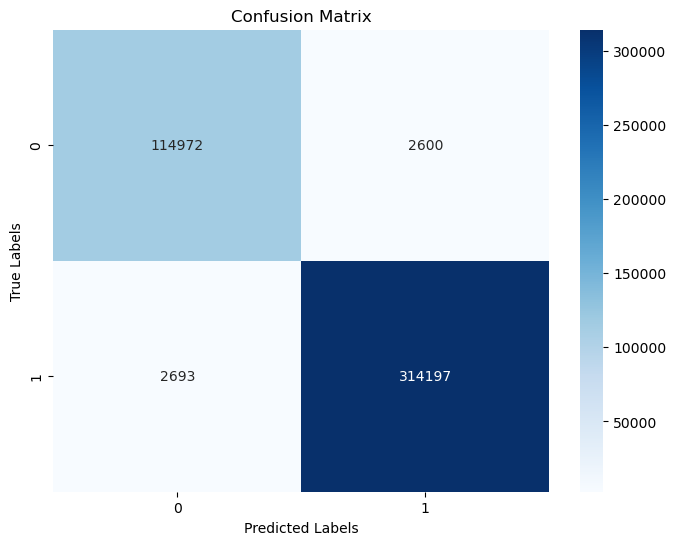

In [304]:
# Calculating Confusion Matrix
confusion_mtx = confusion_matrix(comparable_df['Probability_category'].values,
                                 comparable_df['Prediction_category'].values
                                )

# Ploting
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()


**The confusion matrix** is a useful tool for evaluating the performance of a classification model. It provides information about the number of observations that were correctly and incorrectly classified for each class. The matrix consists of four terms:

*True Positive (TP)*: The number of observations that were correctly classified as positive. These are the cases where the model predicted a positive outcome and the true label is also positive.

*True Negative (TN)*: The number of observations that were correctly classified as negative. These are the cases where the model predicted a negative outcome and the true label is also negative.

*False positive (FP)*: The number of observations that were incorrectly classified as positive. These are the cases where the model predicted a positive outcome but the actual labeling is negative. This is also referred to as a Type I error.

*False Negative (FN)*: The number of observations that were incorrectly classified as negative. These are the cases where the model predicted a negative outcome, but the actual labeling is positive. This is also referred to as a II type error.

The confusion matrix can be used to assess the performance of a classification model in terms of its ability to correctly classify observations from different classes. By analyzing the values in the matrix, we can compute various evaluation metrics such as *Precision, Recall and F1 score*, which provide further insight into the performance of the model.

In [305]:
# Precision:
precision = confusion_mtx[1, 1] / (confusion_mtx[1, 1] + confusion_mtx[0, 1])
print('Precision:', round(precision, 3))

# Recall (True Positive Rate):
recall = confusion_mtx[1, 1] / (confusion_mtx[1, 1] + confusion_mtx[1, 0])
print('Recall:', round(recall, 3))

# F1-Score:
f1_score = 2 * (precision * recall) / (precision + recall)
print('F1-Score:', round(f1_score, 3))

# Accuracy:
accuracy = (confusion_mtx[1, 1] + confusion_mtx[0, 0]) / (confusion_mtx[1, 1] + confusion_mtx[0, 0] + confusion_mtx[0, 1] + confusion_mtx[1, 0])
print('Accuracy:', round(accuracy, 3))

# Calculating AUC-ROC score
auc_roc = roc_auc_score(comparable_df['Probability_category'].values,
                        comparable_df['Prediction_category'].values,
                        multi_class='ovr'
                       )

print("AUC-ROC Score:", round(auc_roc, 3))

Precision: 0.992
Recall: 0.992
F1-Score: 0.992
Accuracy: 0.988
AUC-ROC Score: 0.985


*Precision:* it is the ratio of correctly classified positive observations to the total number of observations classified as positive [TP / (TP + FP)].

*Recall:* it is the ratio of correctly classified positive observations to the total number of actual positive observations [TP / (TP + FN)].

*F1 score:* it is a combined metric that considers both precision and recall [2 * (precision * recall) / (precision + recall)].

*Accuracy:* it is a useful measure for evaluating the overall performance of a model. It measures the proportion of correct predictions relative to the total number of predictions made by the model [(TP + TN) / (TP + TN + FP + FN)].

*AUC-ROC (Area Under the Receiver Operating Characteristic Curve)* is a commonly used metric for evaluating the performance of binary classification models. It measures the ability of the model to distinguish between the two classes (positive and negative) at different classification thresholds, i.e., the ability of the model to correctly classify positive instances as positive and negative instances as negative across all possible classification thresholds. A higher AUC-ROC value indicates better model performance in terms of classification accuracy.

These metrics are commonly used to evaluate the performance of classification models and provide information on how well the model correctly classifies positive and negative classes.


**So, the model performs very well in classifying positive observations.** which means that it can correctly predict the customers in the data frame who are likely to buy Account Sold.

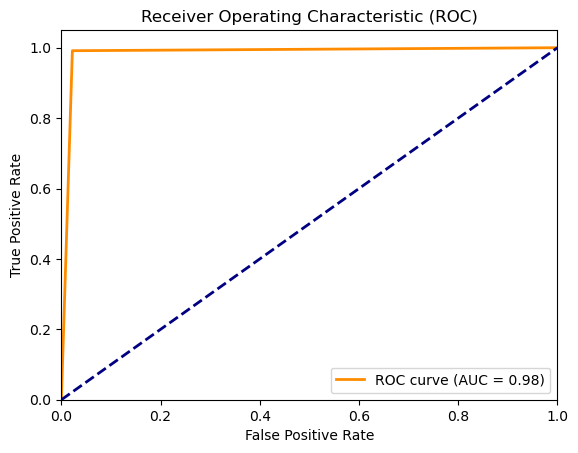

In [306]:

# y_true são as etiquetas reais (0 para negativo e 1 para positivo)
# y_pred_prob são as probabilidades previstas para as observações positivas
fpr, tpr, thresholds = roc_curve(comparable_df['Probability_category'].values,
                                 comparable_df['Prediction_category'].values
                                )
roc_auc = auc(fpr, tpr)

# Plot da curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

plt.show()


*ROC curve* shows the relationship between the false-positive rate (x-axis) and the true-positive rate (y-axis) for different classification thresholds. Each point on the curve represents a particular classification threshold, and the curve itself is formed by connecting these points. the closer it is to the upper left corner, the better the model performance.

*Dashed line* represents the ROC curve of a random classifier that has no discriminative ability. For a model with better performance, the ROC curve is above this line.

*AUC value* is the area under the ROC curve and is a numerical metric that summarizes the performance of the model. The higher the AUC value, the better the performance of the model in discriminating between classes.

These concepts are valuable for evaluating and comparing the performance of binary classification models, particularly for evaluating the model's ability to balance the true-positive rate and the false-positive rate at different classification thresholds.

**Sorting the Importance of Features**

In [307]:
# The feature names are in selected_columns
selected_columns.head()

total_products    salary  age  Account_Sold  segment_01 - TOP  \
1469193             1.0  88654.65   59          True                 0   
2943551             0.0  88654.65   62         False                 0   
3604761             0.0  88654.65   62         False                 0   
4002815             0.0  88654.65   62         False                 0   
4451602             0.0  88654.65   62         False                 0   

         segment_02 - PARTICULARES  segment_03 - UNIVERSITARIO  \
1469193                          1                           0   
2943551                          1                           0   
3604761                          1                           0   
4002815                          1                           0   
4451602                          1                           0   

         segment_04 - NO INFO  country_id_AR  country_id_AT  ...  \
1469193                     0              0              0  ...   
2943551                     0              0              0  ...   
3604761                     0              0              0  ...   
4002815                     0              0              0  ...   
4451602                     0              0              0  ...   

         country_id_PL  country_id_PT  country_id_QA  country_id_RO  \
1469193              0              0              0              0   
2943551              0              0              0              0   
3604761              0              0              0              0   
4002815              0              0              0              0   
4451602              0              0              0              0   

         country_id_RU  country_id_SA  country_id_SE  country_id_SN  \
1469193              0              0              0              0   
2943551              0              0              0              0   
3604761              0              0              0              0   
4002815              0              0              0              0   
4451602              0              0              0              0   

         country_id_US  country_id_VE  
1469193              0              0  
2943551              0              0  
3604761              0              0  
4002815              0              0  
4451602              0              0  

[5 rows x 49 columns]

Text(0.5, 0, 'Feature Importance')

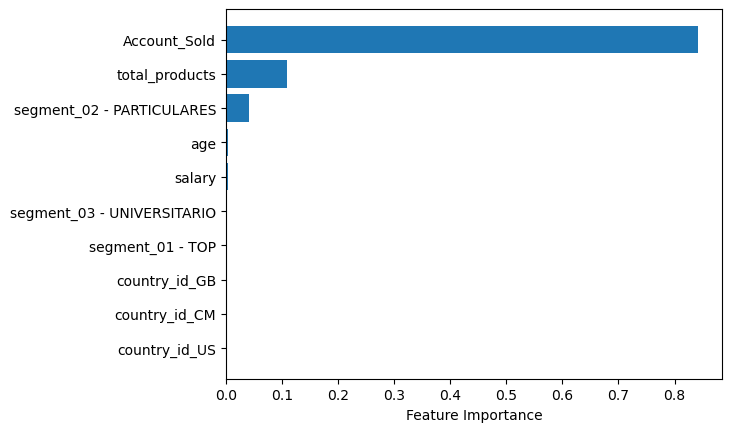

In [308]:
# Sorting features in increasing order of importance
importances = rf_model.feature_importances_
sorted_idx = importances.argsort()

plt.barh(selected_columns.columns[sorted_idx][-10:],
         importances[sorted_idx][-10:]
        )

plt.xlabel("Feature Importance")


The importance of different features in predicting the target variable is depicted in this graph. The height of each bar represents the relative influence of a feature in determining the outcome. Based on the graph, the most influential features, ranked in order, are 'Account Sold', 'total_products', 'age', and 'salary'.

The significance of these features suggests that a customer's previous purchase history, the total number of products purchased, age, and salary are key factors in determining whether they will buy an Account Sold product.

On the other hand, the graph indicates that the 'segment' and 'country_id' features have relatively low importance in predicting the purchase of an Account Sold product. This implies that a customer's segment membership and country of origin have limited influence on their decision to buy this specific product.

These insights provide valuable information about the driving factors behind customer decisions to purchase or not purchase an Account Sold product, helping to improve our understanding of customer behavior in this context.

# **Machine Learning for Savings and Investments**

So, after carefully analysing Account sold and predicting the probability that each customer will buy this product, it is necessary to do the same for *savings and investments*.

In [309]:
# Creating DF
df_sav_inv = df_acc_sold.copy()
df_sav_inv.drop(['Account_Sold','previous_value'], axis=1,inplace=True)
df_sav_inv = pd.concat([df_sav_inv, mapped_df['Savings_Investments']], axis=1)

df_sav_inv

pk_partition   pk_cid  active_customer  total_products    salary  age  \
1469193   2018-07-28    15891                1             1.0  88654.65   59   
2153344   2018-08-28    15891                0             0.0  88654.65   59   
2943551   2018-11-28    16063                1             0.0  88654.65   62   
3604761   2018-12-28    16063                1             0.0  88654.65   62   
4002815   2019-01-28    16063                1             0.0  88654.65   62   
...              ...      ...              ...             ...       ...  ...   
5639601   2019-05-28  1553685                0             0.0  88654.65   52   
5639600   2019-05-28  1553686                0             0.0  88654.65   30   
5639599   2019-05-28  1553687                0             0.0  88654.65   21   
5639598   2019-05-28  1553688                0             0.0  88654.65   43   
5639597   2019-05-28  1553689                0             0.0  88654.65   40   

         segment_01 - TOP  segment_02 - PARTICULARES  \
1469193                 0                          1   
2153344                 0                          1   
2943551                 0                          1   
3604761                 0                          1   
4002815                 0                          1   
...                   ...                        ...   
5639601                 0                          0   
5639600                 0                          0   
5639599                 0                          0   
5639598                 0                          0   
5639597                 0                          0   

         segment_03 - UNIVERSITARIO  segment_04 - NO INFO  ...  country_id_RO  \
1469193                           0                     0  ...              0   
2153344                           0                     0  ...              0   
2943551                           0                     0  ...              0   
3604761                           0                     0  ...              0   
4002815                           0                     0  ...              0   
...                             ...                   ...  ...            ...   
5639601                           0                     1  ...              0   
5639600                           0                     1  ...              0   
5639599                           0                     1  ...              0   
5639598                           0                     1  ...              0   
5639597                           0                     1  ...              0   

         country_id_RU  country_id_SA  country_id_SE  country_id_SN  \
1469193              0              0              0              0   
2153344              0              0              0              0   
2943551              0              0              0              0   
3604761              0              0              0              0   
4002815              0              0              0              0   
...                ...            ...            ...            ...   
5639601              0              0              0              0   
5639600              0              0              0              0   
5639599              0              0              0              0   
5639598              0              0              0              0   
5639597              0              0              0              0   

         country_id_US  country_id_VE  Year  Month  Savings_Investments  
1469193              0              0  2018      7                False  
2153344              0              0  2018      8                False  
2943551              0              0  2018     11                False  
3604761              0              0  2018     12                False  
4002815              0              0  2019      1                False  
...                ...            ...   ...    ...                  ...  
5639601           

**Analysis customer purchasing behaviour for Savings and Investment products over time.**

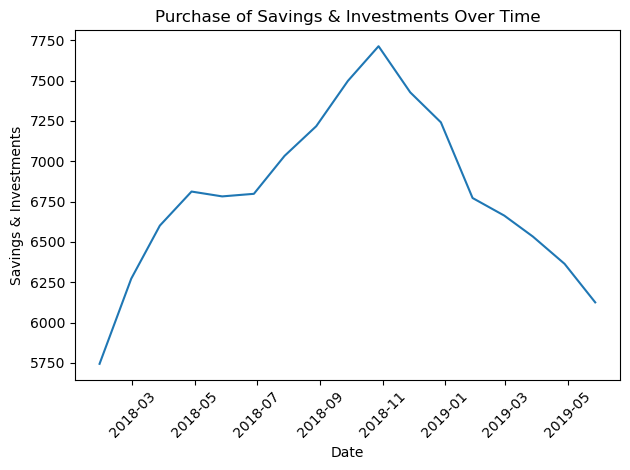

In [310]:
# Creating a copy of original df
df_sav_inv_1 = df_sav_inv.copy()

# Set pk_partition (date), as index
df_sav_inv_1.set_index('pk_partition', inplace=True)

# Group by Date and sum all Account Sold for each month
df_sav_inv_1['Date'] = df_sav_inv_1.index.date
df_sav_inv_1 = df_sav_inv_1.groupby('Date')['Savings_Investments'].sum().reset_index()

plt.plot(df_sav_inv_1['Date'], df_sav_inv_1['Savings_Investments'])
plt.xlabel('Date')
plt.ylabel('Savings & Investments')
plt.title('Purchase of Savings & Investments Over Time')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

The figure above shows the pattern of purchase of this type of product. Demand seems to be higher until November 2018, with a slight decrease from May to July. However, after that, the search for this type of product went downhill again.

Perhaps it is important to evaluate the type of marketing campaigns that were conducted from July to November that boosted the purchase of these products, and try to do the same.

In [311]:
top_cost_s_v = df_sav_inv.groupby('pk_cid')['Savings_Investments'].sum().nlargest(5)
print("Top Customers that Purchase Products from Savings and Investments:")
print(top_cost_acc)

Top Customers that Purchase Products from Savings and Investments:
pk_cid
17457    17
17799    17
17970    17
18704    17
19268    17
19684    17
20333    17
20417    17
21551    17
22212    17
25036    17
25054    17
25398    17
26018    17
26163    17
Name: Account_Sold, dtype: int64


In [312]:
# Calculate purchase behavior metrics for countries
top_act_s_v = df_sav_inv.groupby('active_customer')['Savings_Investments'].mean()

# Print the top countries with the highest purchase counts
print("Average Savings and Investments Purchased by Active and Inactive Customers:")
print(top_act_s_v)

Average Savings and Investments Purchased by Active and Inactive Customers:
active_customer
0    0.000779
1    0.047567
Name: Savings_Investments, dtype: float64


In [313]:
# Shifting a month for each customer, so that the last month is the predious values for every customer
df_sav_inv['previous_value'] = df_sav_inv.groupby(['pk_cid'])['Savings_Investments'].shift(-1)
df_sav_inv

pk_partition   pk_cid  active_customer  total_products    salary  age  \
1469193   2018-07-28    15891                1             1.0  88654.65   59   
2153344   2018-08-28    15891                0             0.0  88654.65   59   
2943551   2018-11-28    16063                1             0.0  88654.65   62   
3604761   2018-12-28    16063                1             0.0  88654.65   62   
4002815   2019-01-28    16063                1             0.0  88654.65   62   
...              ...      ...              ...             ...       ...  ...   
5639601   2019-05-28  1553685                0             0.0  88654.65   52   
5639600   2019-05-28  1553686                0             0.0  88654.65   30   
5639599   2019-05-28  1553687                0             0.0  88654.65   21   
5639598   2019-05-28  1553688                0             0.0  88654.65   43   
5639597   2019-05-28  1553689                0             0.0  88654.65   40   

         segment_01 - TOP  segment_02 - PARTICULARES  \
1469193                 0                          1   
2153344                 0                          1   
2943551                 0                          1   
3604761                 0                          1   
4002815                 0                          1   
...                   ...                        ...   
5639601                 0                          0   
5639600                 0                          0   
5639599                 0                          0   
5639598                 0                          0   
5639597                 0                          0   

         segment_03 - UNIVERSITARIO  segment_04 - NO INFO  ...  country_id_RU  \
1469193                           0                     0  ...              0   
2153344                           0                     0  ...              0   
2943551                           0                     0  ...              0   
3604761                           0                     0  ...              0   
4002815                           0                     0  ...              0   
...                             ...                   ...  ...            ...   
5639601                           0                     1  ...              0   
5639600                           0                     1  ...              0   
5639599                           0                     1  ...              0   
5639598                           0                     1  ...              0   
5639597                           0                     1  ...              0   

         country_id_SA  country_id_SE  country_id_SN  country_id_US  \
1469193              0              0              0              0   
2153344              0              0              0              0   
2943551              0              0              0              0   
3604761              0              0              0              0   
4002815              0              0              0              0   
...                ...            ...            ...            ...   
5639601              0              0              0              0   
5639600              0              0              0              0   
5639599              0              0              0              0   
5639598              0              0              0              0   
5639597              0              0              0              0   

         country_id_VE  Year  Month  Savings_Investments  previous_value  
1469193              0  2018      7                False           False  
2153344              0  2018      8                False             NaN  
2943551              0  2018     11                False           False  
3604761              0  2018     12                False           False  
4002815              0  2019      1                False           False  
...                ...   ...    ...                  ...             ...  
5639601    

In [314]:
# this should be equivelent to the numeber of total customers
df_sav_inv['previous_value'].isnull().sum()

452197

In [315]:
# Discovering how many entries this df has each year (2018 and 2019)
df_sav_inv['Year'] = df_sav_inv['pk_partition'].dt.year
df_sav_inv['Month'] = df_sav_inv['pk_partition'].dt.month


df_acc_sold['Year'].value_counts()

2018    3761238
2019    2159426
Name: Year, dtype: int64

**Separating Training, Validation and Test sets:**


In [316]:
# Creating Training, Validation, and Test set
train_df = df_sav_inv[((df_sav_inv['Year'] == 2018) | ((df_sav_inv['Year'] == 2019) & (df_sav_inv['Month'] < 4)))]
val_df = df_sav_inv[(df_sav_inv['Year'] == 2019) & (df_sav_inv['Month'] == 4)]
test_df = df_sav_inv[(df_sav_inv['Year'] == 2019) & (df_sav_inv['Month'] == 5)]


In [317]:
print(train_df.shape)
print(train_df.shape[0]/df_sav_inv.shape[0])

(5046026, 55)
0.8522736638998599


In [318]:
train_df.dropna(inplace=True)

/var/folders/gx/5k88wzkx0zv8bsfz2nt93d0h0000gn/T/ipykernel_777/519058362.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [319]:
print(val_df.shape)
print(val_df.shape[0]/df_sav_inv.shape[0])

(435644, 55)
0.07358026059239302


In [320]:
val_df.dropna(inplace=True)

/var/folders/gx/5k88wzkx0zv8bsfz2nt93d0h0000gn/T/ipykernel_777/3017562600.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [321]:
print(test_df.shape)
print(test_df.shape[0]/df_sav_inv.shape[0])

(438994, 55)
0.0741460755077471


**Training the Model**

In [322]:
train_df.drop(['Year','Month'], axis=1, inplace=True)
select_col = train_df.iloc[:, 3:-1]
select_col

/var/folders/gx/5k88wzkx0zv8bsfz2nt93d0h0000gn/T/ipykernel_777/1407446580.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



total_products    salary  age  segment_01 - TOP  \
1469193             1.0  88654.65   59                 0   
2943551             0.0  88654.65   62                 0   
3604761             0.0  88654.65   62                 0   
4002815             0.0  88654.65   62                 0   
4451602             0.0  88654.65   62                 0   
...                 ...       ...  ...               ...   
4845206             0.0  88654.65   33                 0   
4845205             0.0  88654.65   33                 0   
4845204             0.0  88654.65   35                 0   
4845203             0.0  88654.65   34                 0   
4845202             0.0  88654.65   39                 0   

         segment_02 - PARTICULARES  segment_03 - UNIVERSITARIO  \
1469193                          1                           0   
2943551                          1                           0   
3604761                          1                           0   
4002815                          1                           0   
4451602                          1                           0   
...                            ...                         ...   
4845206                          1                           0   
4845205                          1                           0   
4845204                          1                           0   
4845203                          1                           0   
4845202                          1                           0   

         segment_04 - NO INFO  country_id_AR  country_id_AT  country_id_BE  \
1469193                     0              0              0              0   
2943551                     0              0              0              0   
3604761                     0              0              0              0   
4002815                     0              0              0              0   
4451602                     0              0              0              0   
...                       ...            ...            ...            ...   
4845206                     0              0              0              0   
4845205                     0              0              0              0   
4845204                     0              0              0              0   
4845203                     0              0              0              0   
4845202                     0              0              0              0   

         ...  country_id_PT  country_id_QA  country_id_RO  country_id_RU  \
1469193  ...              0              0              0              0   
2943551  ...              0              0              0              0   
3604761  ...              0              0              0              0   
4002815  ...              0              0              0              0   
4451602  ...              0              0              0              0   
...      ...            ...            ...            ...            ...   
4845206  ...              0              0              0              0   
4845205  ...              0              0              0              0   
4845204  ...              0              0              0              0   
4845203  ...              0              0              0              0   
4845202  ...              0              0              0              0   

         country_id_SA  country_id_SE  country_id_SN  country_id_US  \
1469193              0              0              0              0   
2943551              0              0              0              0   
3604761              0              0              0              0   
4002815              0              0              0              0   
4451602              0              0              0              0   
...                ...            ...            ...            ...   
4845206              0              0              0              0   
4845205              0              0              0              0   
484520

In [323]:
train_df['previous_value'] = train_df['previous_value'].astype(int)

/var/folders/gx/5k88wzkx0zv8bsfz2nt93d0h0000gn/T/ipykernel_777/2630694047.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [324]:
rf_model = RandomForestClassifier(n_estimators=3,
                                  max_depth=5,
                                  random_state=42
                                 )

rf_model.fit(select_col, train_df['previous_value'])

RandomForestClassifier(max_depth=5, n_estimators=3, random_state=42)

In [325]:
Counter(train_df['previous_value'])

Counter({0: 4932791, 1: 101214})

In [326]:
test_df['Prediction'] = rf_model.predict_proba(test_df[select_col.columns])[:, 1]
test_df

/var/folders/gx/5k88wzkx0zv8bsfz2nt93d0h0000gn/T/ipykernel_777/1088415128.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



pk_partition   pk_cid  active_customer  total_products     salary  \
5485117   2019-05-28    16063                0             0.0   88654.65   
5485116   2019-05-28    16203                1             1.0   88654.65   
5485115   2019-05-28    16502                1             2.0   88654.65   
5485118   2019-05-28    17457                1             3.0  102405.75   
5485109   2019-05-28    17590                1             0.0  407281.11   
...              ...      ...              ...             ...        ...   
5639601   2019-05-28  1553685                0             0.0   88654.65   
5639600   2019-05-28  1553686                0             0.0   88654.65   
5639599   2019-05-28  1553687                0             0.0   88654.65   
5639598   2019-05-28  1553688                0             0.0   88654.65   
5639597   2019-05-28  1553689                0             0.0   88654.65   

         age  segment_01 - TOP  segment_02 - PARTICULARES  \
5485117   62                 0                          1   
5485116   70                 1                          0   
5485115   58                 0                          1   
5485118   54                 0                          1   
5485109   55                 0                          1   
...      ...               ...                        ...   
5639601   52                 0                          0   
5639600   30                 0                          0   
5639599   21                 0                          0   
5639598   43                 0                          0   
5639597   40                 0                          0   

         segment_03 - UNIVERSITARIO  segment_04 - NO INFO  ...  country_id_SA  \
5485117                           0                     0  ...              0   
5485116                           0                     0  ...              0   
5485115                           0                     0  ...              0   
5485118                           0                     0  ...              0   
5485109                           0                     0  ...              0   
...                             ...                   ...  ...            ...   
5639601                           0                     1  ...              0   
5639600                           0                     1  ...              0   
5639599                           0                     1  ...              0   
5639598                           0                     1  ...              0   
5639597                           0                     1  ...              0   

         country_id_SE  country_id_SN  country_id_US  country_id_VE  Year  \
5485117              0              0              0              0  2019   
5485116              0              0              0              0  2019   
5485115              0              0              0              0  2019   
5485118              0              0              0              0  2019   
5485109              0              0              0              0  2019   
...                ...            ...            ...            ...   ...   
5639601              0              0              0              0  2019   
5639600              0              0              0              0  2019   
5639599              0              0              0              0  2019   
5639598              0              0              0              0  2019   
5639597              0              0              0              0  2019   

         Month  Savings_Investments  previous_value  Prediction  
5485117      5                False             NaN    0.008531  
5485116      5                False             NaN    0.186898  
5485115      5                False             NaN    0.055807  
5485118      5                 True             NaN    0.391331  
5485109      5                False             NaN    0.034240  
...        ...                  ...             ...     

In [327]:
val_df['Probability'] = rf_model.predict_proba(val_df[select_col.columns])[:,1]
val_df

/var/folders/gx/5k88wzkx0zv8bsfz2nt93d0h0000gn/T/ipykernel_777/3808948050.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



pk_partition   pk_cid  active_customer  total_products     salary  \
5098294   2019-04-28    16063                1             0.0   88654.65   
5098298   2019-04-28    16203                1             1.0   88654.65   
5098297   2019-04-28    16502                1             2.0   88654.65   
5098229   2019-04-28    17457                1             2.0  102405.75   
5098230   2019-04-28    17590                1             0.0  407281.11   
...              ...      ...              ...             ...        ...   
5064899   2019-04-28  1548202                0             0.0   88654.65   
5064900   2019-04-28  1548203                0             0.0   88654.65   
5064901   2019-04-28  1548204                0             0.0   88654.65   
5064902   2019-04-28  1548206                0             0.0   88654.65   
5064903   2019-04-28  1548207                0             0.0   88654.65   

         age  segment_01 - TOP  segment_02 - PARTICULARES  \
5098294   62                 0                          1   
5098298   70                 1                          0   
5098297   58                 0                          1   
5098229   54                 0                          1   
5098230   55                 0                          1   
...      ...               ...                        ...   
5064899   22                 0                          1   
5064900   51                 0                          1   
5064901   54                 0                          1   
5064902   40                 0                          1   
5064903   32                 0                          1   

         segment_03 - UNIVERSITARIO  segment_04 - NO INFO  ...  country_id_SA  \
5098294                           0                     0  ...              0   
5098298                           0                     0  ...              0   
5098297                           0                     0  ...              0   
5098229                           0                     0  ...              0   
5098230                           0                     0  ...              0   
...                             ...                   ...  ...            ...   
5064899                           0                     0  ...              0   
5064900                           0                     0  ...              0   
5064901                           0                     0  ...              0   
5064902                           0                     0  ...              0   
5064903                           0                     0  ...              0   

         country_id_SE  country_id_SN  country_id_US  country_id_VE  Year  \
5098294              0              0              0              0  2019   
5098298              0              0              0              0  2019   
5098297              0              0              0              0  2019   
5098229              0              0              0              0  2019   
5098230              0              0              0              0  2019   
...                ...            ...            ...            ...   ...   
5064899              0              0              0              0  2019   
5064900              0              0              0              0  2019   
5064901              0              0              0              0  2019   
5064902              0              0              0              0  2019   
5064903              0              0              0              0  2019   

         Month  Savings_Investments  previous_value  Probability  
5098294      4                False           False     0.008531  
5098298      4                False           False     0.186898  
5098297      4                False           False     0.055807  
5098229      4                 True            True     0.391331  
5098230      4                False           False     0.034240  
...        ...                  ...             ..

In [328]:
# Merging the Predictions and Probability in a DF
compare_df = test_df[['pk_cid', 'Prediction']].merge(val_df[['pk_cid', 'Probability']], on='pk_cid', how='inner')
compare_df

pk_cid  Prediction  Probability
0         16063    0.008531     0.008531
1         16203    0.186898     0.186898
2         16502    0.055807     0.055807
3         17457    0.391331     0.391331
4         17590    0.034240     0.034240
...         ...         ...          ...
434457  1548202    0.012877     0.012064
434458  1548203    0.009344     0.008531
434459  1548204    0.008531     0.008531
434460  1548206    0.005672     0.005672
434461  1548207    0.012064     0.012064

[434462 rows x 3 columns]

**Evaluation of the Random Forest Model**

In [329]:
# Turning the probabilities into binary classification
threshold = 0.5
compare_df['Probability_category'] = compare_df['Probability'].apply(lambda x: 1 if x >= threshold else 0)
compare_df['Prediction_category'] = compare_df['Prediction'].apply(lambda x: 1 if x >= threshold else 0)

compare_df

pk_cid  Prediction  Probability  Probability_category  \
0         16063    0.008531     0.008531                     0   
1         16203    0.186898     0.186898                     0   
2         16502    0.055807     0.055807                     0   
3         17457    0.391331     0.391331                     0   
4         17590    0.034240     0.034240                     0   
...         ...         ...          ...                   ...   
434457  1548202    0.012877     0.012064                     0   
434458  1548203    0.009344     0.008531                     0   
434459  1548204    0.008531     0.008531                     0   
434460  1548206    0.005672     0.005672                     0   
434461  1548207    0.012064     0.012064                     0   

        Prediction_category  
0                         0  
1                         0  
2                         0  
3                         0  
4                         0  
...                     ...  
434457                    0  
434458                    0  
434459                    0  
434460                    0  
434461                    0  

[434462 rows x 5 columns]

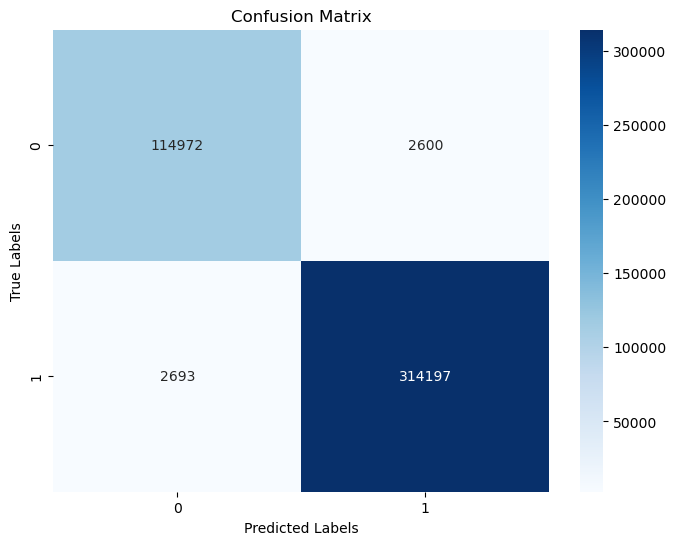

In [330]:
# Calculating Confusion Matrix
confusion_mtx_s_v = confusion_matrix(compare_df['Probability_category'].values,
                                     compare_df['Prediction_category'].values
                                    )

# Ploting
plt.figure(figsize=(8, 6))

sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()


Once again, the majority of the values are concentrated in the True Positive (TP) and True Negative (TN) cells of the confusion matrix, which is a positive indicator. With the help of the confusion matrix, we can calculate important evaluation metrics such as Precision, Recall, F1-score, Accuracy, and AUC-ROC score. These metrics provide valuable insights into the performance and effectiveness of the classification model.

In [331]:
# Precision:
precision = confusion_mtx_s_v[1, 1] / (confusion_mtx_s_v[1, 1] + confusion_mtx_s_v[0, 1])
print('Precision:', round(precision, 3))

# Recall (True Positive Rate):
recall = confusion_mtx_s_v[1, 1] / (confusion_mtx_s_v[1, 1] + confusion_mtx_s_v[1, 0])
print('Recall:', round(recall, 3))

# F1-Score:
f1_score = 2 * (precision * recall) / (precision + recall)
print('F1-Score:', round(f1_score, 3))

# Accuracy:
accuracy = (confusion_mtx_s_v[1, 1] + confusion_mtx_s_v[0, 0]) / (confusion_mtx_s_v[1, 1] + confusion_mtx_s_v[0, 0] + confusion_mtx_s_v[0, 1] + confusion_mtx_s_v[1, 0])
print('Accuracy:', round(accuracy, 3))

# Calculating AUC-ROC score
auc_roc = roc_auc_score(compare_df['Probability_category'].values,
                        compare_df['Prediction_category'].values,
                        multi_class='ovr'
                       )

print("AUC-ROC Score:", round(auc_roc, 3))

Precision: 0.989
Recall: 0.965
F1-Score: 0.977
Accuracy: 1.0
AUC-ROC Score: 0.983


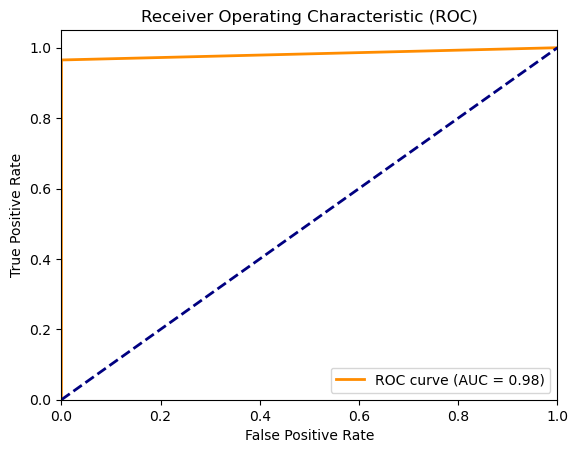

In [332]:
# Ploting the Curve AUC-ROC
fpr, tpr, thresholds = roc_curve(compare_df['Probability_category'].values,
                                 compare_df['Prediction_category'].values
                                )
roc_auc = auc(fpr, tpr)

# Plot da curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

plt.show()


Text(0.5, 0, 'Feature Importance')

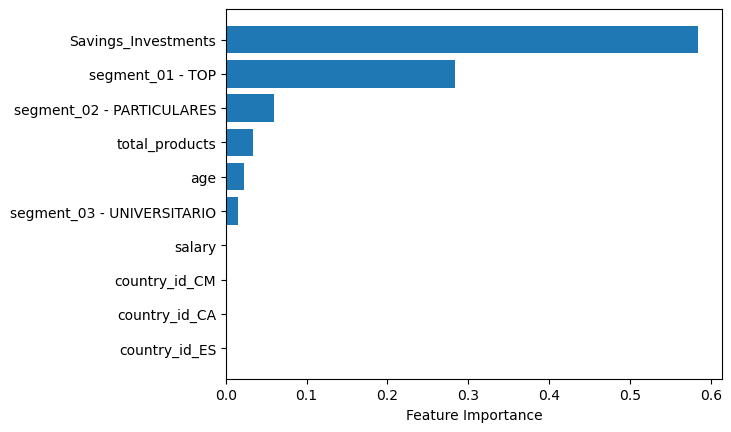

In [333]:
# Sorting features in increasing order of importance.
importances = rf_model.feature_importances_
sorted_idx = importances.argsort()

plt.barh(select_col.columns[sorted_idx][-10:],
         importances[sorted_idx][-10:]
        )

plt.xlabel("Feature Importance")


Savings and Investments differ from those observed for Account Sold.

The most influential feature is whether the customer has previously purchased any type of Savings or Investments. This indicates that customers with prior investment experience are more likely to make further investments. Another important feature is membership in the TOP segment, which suggests that customers with higher financial status or capability are more inclined to invest.

Segment membership also plays a significant role in this product category, unlike what was observed for Account Sold. Being categorized as a PARTICULARES customer, indicating individuals rather than businesses, is the third most important feature. This suggests that personal financial goals and preferences play a significant role in the decision to invest.

The total number of products purchased is another influential factor. Customers who have engaged with the company and purchased multiple products are more likely to consider investing in Savings and Investments.

Age is also a relevant feature, indicating that different age groups may have varying financial needs and objectives, influencing their decision to invest.

Affiliation with the UNIVERSITARIO segment, typically associated with university students or young professionals, is of some relevance. This suggests that younger individuals may be more inclined to invest in Savings and Investments.

Similar to Account Sold, the customer's country of origin has a minor influence on the decision to purchase these products. Additionally, customer salary does not play a significant role in this context, indicating that income level is not a determining factor for investing in Savings and Investments.

These insights shed light on the factors that drive customer decisions in purchasing Savings and Investments, providing valuable information for understanding customer behavior in this product category.

# **Machine Learning for Financing Products**

In [334]:
# Creating DF
df_financing = df_acc_sold.copy()
df_financing.drop(['Account_Sold','previous_value'], axis=1,inplace=True)
df_financing = pd.concat([df_financing, mapped_df['Financing_Products']], axis=1)

df_financing


pk_partition   pk_cid  active_customer  total_products    salary  age  \
1469193   2018-07-28    15891                1             1.0  88654.65   59   
2153344   2018-08-28    15891                0             0.0  88654.65   59   
2943551   2018-11-28    16063                1             0.0  88654.65   62   
3604761   2018-12-28    16063                1             0.0  88654.65   62   
4002815   2019-01-28    16063                1             0.0  88654.65   62   
...              ...      ...              ...             ...       ...  ...   
5639601   2019-05-28  1553685                0             0.0  88654.65   52   
5639600   2019-05-28  1553686                0             0.0  88654.65   30   
5639599   2019-05-28  1553687                0             0.0  88654.65   21   
5639598   2019-05-28  1553688                0             0.0  88654.65   43   
5639597   2019-05-28  1553689                0             0.0  88654.65   40   

         segment_01 - TOP  segment_02 - PARTICULARES  \
1469193                 0                          1   
2153344                 0                          1   
2943551                 0                          1   
3604761                 0                          1   
4002815                 0                          1   
...                   ...                        ...   
5639601                 0                          0   
5639600                 0                          0   
5639599                 0                          0   
5639598                 0                          0   
5639597                 0                          0   

         segment_03 - UNIVERSITARIO  segment_04 - NO INFO  ...  country_id_RO  \
1469193                           0                     0  ...              0   
2153344                           0                     0  ...              0   
2943551                           0                     0  ...              0   
3604761                           0                     0  ...              0   
4002815                           0                     0  ...              0   
...                             ...                   ...  ...            ...   
5639601                           0                     1  ...              0   
5639600                           0                     1  ...              0   
5639599                           0                     1  ...              0   
5639598                           0                     1  ...              0   
5639597                           0                     1  ...              0   

         country_id_RU  country_id_SA  country_id_SE  country_id_SN  \
1469193              0              0              0              0   
2153344              0              0              0              0   
2943551              0              0              0              0   
3604761              0              0              0              0   
4002815              0              0              0              0   
...                ...            ...            ...            ...   
5639601              0              0              0              0   
5639600              0              0              0              0   
5639599              0              0              0              0   
5639598              0              0              0              0   
5639597              0              0              0              0   

         country_id_US  country_id_VE  Year  Month  Financing_Products  
1469193              0              0  2018      7               False  
2153344              0              0  2018      8               False  
2943551              0              0  2018     11               False  
3604761              0              0  2018     12               False  
4002815              0              0  2019      1               False  
...                ...            ...   ...    ...                 ...  
5639601              0   

**Analysis customer purchasing behaviour for Financing products over time.**

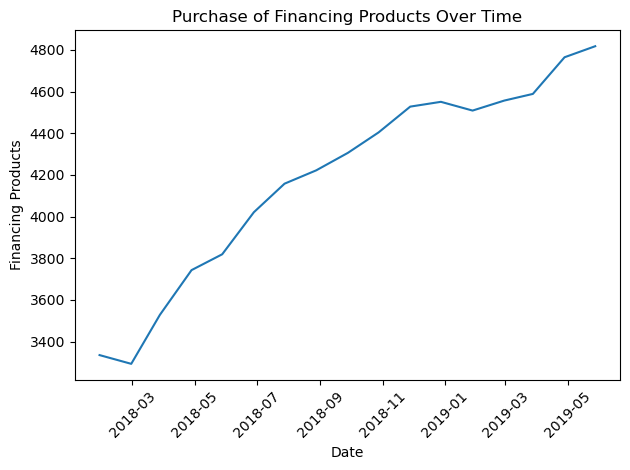

In [335]:
# Creating a copy of original df
df_financing_1 = df_financing.copy()

# Set pk_partition (date), as index
df_financing_1.set_index('pk_partition', inplace=True)


# Group by Date and sum all Account Sold for each month
df_financing_1['Date'] = df_financing_1.index.date
df_financing_1 = df_financing_1.groupby('Date')['Financing_Products'].sum().reset_index()

# Plotting
plt.plot(df_financing_1['Date'], df_financing_1['Financing_Products'])
plt.xlabel('Date')
plt.ylabel('Financing Products')
plt.title('Purchase of Financing Products Over Time')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

Similar to the trend observed for Account Sold, there is also an increasing demand for Financing Products over time.

In [336]:
top_cost_f = df_financing.groupby('pk_cid')['Financing_Products'].sum().nlargest(5)
print("Top Customers that Purchase Products from Financing:")
print(top_cost_f)


Top Customers that Purchase Products from Financing:
pk_cid
40486    17
66463    17
68600    17
79129    17
79355    17
Name: Financing_Products, dtype: int64


In [337]:
# Calculate purchase behavior metrics for countries
top_act_f = df_financing.groupby('active_customer')['Financing_Products'].mean()

# Print the top countries with the highest purchase counts
print("Average Financing Products Purchased by Active and Inactive Customers:")
print(top_act_f)


Average Financing Products Purchased by Active and Inactive Customers:
active_customer
0    0.000255
1    0.029612
Name: Financing_Products, dtype: float64


In [338]:
# Shifting a month for each customer, so that the last month is the predious values for every customer
df_financing['previous_value'] = df_financing.groupby(['pk_cid'])['Financing_Products'].shift(-1)
df_financing


pk_partition   pk_cid  active_customer  total_products    salary  age  \
1469193   2018-07-28    15891                1             1.0  88654.65   59   
2153344   2018-08-28    15891                0             0.0  88654.65   59   
2943551   2018-11-28    16063                1             0.0  88654.65   62   
3604761   2018-12-28    16063                1             0.0  88654.65   62   
4002815   2019-01-28    16063                1             0.0  88654.65   62   
...              ...      ...              ...             ...       ...  ...   
5639601   2019-05-28  1553685                0             0.0  88654.65   52   
5639600   2019-05-28  1553686                0             0.0  88654.65   30   
5639599   2019-05-28  1553687                0             0.0  88654.65   21   
5639598   2019-05-28  1553688                0             0.0  88654.65   43   
5639597   2019-05-28  1553689                0             0.0  88654.65   40   

         segment_01 - TOP  segment_02 - PARTICULARES  \
1469193                 0                          1   
2153344                 0                          1   
2943551                 0                          1   
3604761                 0                          1   
4002815                 0                          1   
...                   ...                        ...   
5639601                 0                          0   
5639600                 0                          0   
5639599                 0                          0   
5639598                 0                          0   
5639597                 0                          0   

         segment_03 - UNIVERSITARIO  segment_04 - NO INFO  ...  country_id_RU  \
1469193                           0                     0  ...              0   
2153344                           0                     0  ...              0   
2943551                           0                     0  ...              0   
3604761                           0                     0  ...              0   
4002815                           0                     0  ...              0   
...                             ...                   ...  ...            ...   
5639601                           0                     1  ...              0   
5639600                           0                     1  ...              0   
5639599                           0                     1  ...              0   
5639598                           0                     1  ...              0   
5639597                           0                     1  ...              0   

         country_id_SA  country_id_SE  country_id_SN  country_id_US  \
1469193              0              0              0              0   
2153344              0              0              0              0   
2943551              0              0              0              0   
3604761              0              0              0              0   
4002815              0              0              0              0   
...                ...            ...            ...            ...   
5639601              0              0              0              0   
5639600              0              0              0              0   
5639599              0              0              0              0   
5639598              0              0              0              0   
5639597              0              0              0              0   

         country_id_VE  Year  Month  Financing_Products  previous_value  
1469193              0  2018      7               False           False  
2153344              0  2018      8               False             NaN  
2943551              0  2018     11               False           False  
3604761              0  2018     12               False           False  
4002815              0  2019      1               False           False  
...                ...   ...    ...                 ...             ...  
5639601           

In [339]:
# this should be equivelent to the numeber of total customers
df_financing['previous_value'].isnull().sum()

452197

In [340]:
df_financing['Year'] = df_financing['pk_partition'].dt.year
df_financing['Month'] = df_financing['pk_partition'].dt.month

df_financing['Year'].value_counts()

2018    3761238
2019    2159426
Name: Year, dtype: int64

**Separating Training, Validation and Test sets:**


In [341]:
# Creating Training, Validation, and Test set
train_df = df_financing[((df_sav_inv['Year'] == 2018) | ((df_financing['Year'] == 2019) & (df_financing['Month'] < 4)))]
val_df = df_financing[(df_sav_inv['Year'] == 2019) & (df_financing['Month'] == 4)]
test_df = df_financing[(df_sav_inv['Year'] == 2019) & (df_financing['Month'] == 5)]


In [342]:
train_df['previous_value'].isnull().sum()

12021

In [343]:
train_df.dropna(inplace=True)

/var/folders/gx/5k88wzkx0zv8bsfz2nt93d0h0000gn/T/ipykernel_777/519058362.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [344]:
val_df['previous_value'].isnull().sum()

1182

In [345]:
val_df.dropna(inplace=True)

/var/folders/gx/5k88wzkx0zv8bsfz2nt93d0h0000gn/T/ipykernel_777/3017562600.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [346]:
test_df['previous_value'].isnull().sum()

438994

In [347]:
print('Train Set:')
print(train_df.shape)
print(train_df.shape[0]/df_sav_inv.shape[0])

print('Validation Set:')
print(val_df.shape)
print(val_df.shape[0]/df_sav_inv.shape[0])

print('Test Set:')
print(test_df.shape)
print(test_df.shape[0]/df_sav_inv.shape[0])

Train Set:
(5034005, 55)
0.8502433173035997
Validation Set:
(434462, 55)
0.07338062082225913
Test Set:
(438994, 55)
0.0741460755077471


**Training the Model**

In [348]:
train_df.drop(['Year','Month'], axis=1, inplace=True)
selected_col = train_df.iloc[:, 3:-1]
selected_col

/var/folders/gx/5k88wzkx0zv8bsfz2nt93d0h0000gn/T/ipykernel_777/656920210.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



total_products    salary  age  segment_01 - TOP  \
1469193             1.0  88654.65   59                 0   
2943551             0.0  88654.65   62                 0   
3604761             0.0  88654.65   62                 0   
4002815             0.0  88654.65   62                 0   
4451602             0.0  88654.65   62                 0   
...                 ...       ...  ...               ...   
4845206             0.0  88654.65   33                 0   
4845205             0.0  88654.65   33                 0   
4845204             0.0  88654.65   35                 0   
4845203             0.0  88654.65   34                 0   
4845202             0.0  88654.65   39                 0   

         segment_02 - PARTICULARES  segment_03 - UNIVERSITARIO  \
1469193                          1                           0   
2943551                          1                           0   
3604761                          1                           0   
4002815                          1                           0   
4451602                          1                           0   
...                            ...                         ...   
4845206                          1                           0   
4845205                          1                           0   
4845204                          1                           0   
4845203                          1                           0   
4845202                          1                           0   

         segment_04 - NO INFO  country_id_AR  country_id_AT  country_id_BE  \
1469193                     0              0              0              0   
2943551                     0              0              0              0   
3604761                     0              0              0              0   
4002815                     0              0              0              0   
4451602                     0              0              0              0   
...                       ...            ...            ...            ...   
4845206                     0              0              0              0   
4845205                     0              0              0              0   
4845204                     0              0              0              0   
4845203                     0              0              0              0   
4845202                     0              0              0              0   

         ...  country_id_PT  country_id_QA  country_id_RO  country_id_RU  \
1469193  ...              0              0              0              0   
2943551  ...              0              0              0              0   
3604761  ...              0              0              0              0   
4002815  ...              0              0              0              0   
4451602  ...              0              0              0              0   
...      ...            ...            ...            ...            ...   
4845206  ...              0              0              0              0   
4845205  ...              0              0              0              0   
4845204  ...              0              0              0              0   
4845203  ...              0              0              0              0   
4845202  ...              0              0              0              0   

         country_id_SA  country_id_SE  country_id_SN  country_id_US  \
1469193              0              0              0              0   
2943551              0              0              0              0   
3604761              0              0              0              0   
4002815              0              0              0              0   
4451602              0              0              0              0   
...                ...            ...            ...            ...   
4845206              0              0              0              0   
4845205              0              0              0              0   
484520

In [349]:
train_df['previous_value'] = train_df['previous_value'].astype(int)

/var/folders/gx/5k88wzkx0zv8bsfz2nt93d0h0000gn/T/ipykernel_777/2630694047.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [350]:
rf_model = RandomForestClassifier(n_estimators=3,
                                  max_depth=5,
                                  random_state=42
                                 )

rf_model.fit(selected_col, train_df['previous_value'])

RandomForestClassifier(max_depth=5, n_estimators=3, random_state=42)

In [351]:
# Counting the total amount of 0 and 1
Counter(train_df['previous_value'])

Counter({0: 4971165, 1: 62840})

Since Financing Products are more expensive, the deviation towards non-purchase was expected.

In [352]:
test_df['Prediction'] = rf_model.predict_proba(test_df[selected_col.columns])[:, 1]
test_df

/var/folders/gx/5k88wzkx0zv8bsfz2nt93d0h0000gn/T/ipykernel_777/3188752803.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



pk_partition   pk_cid  active_customer  total_products     salary  \
5485117   2019-05-28    16063                0             0.0   88654.65   
5485116   2019-05-28    16203                1             1.0   88654.65   
5485115   2019-05-28    16502                1             2.0   88654.65   
5485118   2019-05-28    17457                1             3.0  102405.75   
5485109   2019-05-28    17590                1             0.0  407281.11   
...              ...      ...              ...             ...        ...   
5639601   2019-05-28  1553685                0             0.0   88654.65   
5639600   2019-05-28  1553686                0             0.0   88654.65   
5639599   2019-05-28  1553687                0             0.0   88654.65   
5639598   2019-05-28  1553688                0             0.0   88654.65   
5639597   2019-05-28  1553689                0             0.0   88654.65   

         age  segment_01 - TOP  segment_02 - PARTICULARES  \
5485117   62                 0                          1   
5485116   70                 1                          0   
5485115   58                 0                          1   
5485118   54                 0                          1   
5485109   55                 0                          1   
...      ...               ...                        ...   
5639601   52                 0                          0   
5639600   30                 0                          0   
5639599   21                 0                          0   
5639598   43                 0                          0   
5639597   40                 0                          0   

         segment_03 - UNIVERSITARIO  segment_04 - NO INFO  ...  country_id_SA  \
5485117                           0                     0  ...              0   
5485116                           0                     0  ...              0   
5485115                           0                     0  ...              0   
5485118                           0                     0  ...              0   
5485109                           0                     0  ...              0   
...                             ...                   ...  ...            ...   
5639601                           0                     1  ...              0   
5639600                           0                     1  ...              0   
5639599                           0                     1  ...              0   
5639598                           0                     1  ...              0   
5639597                           0                     1  ...              0   

         country_id_SE  country_id_SN  country_id_US  country_id_VE  Year  \
5485117              0              0              0              0  2019   
5485116              0              0              0              0  2019   
5485115              0              0              0              0  2019   
5485118              0              0              0              0  2019   
5485109              0              0              0              0  2019   
...                ...            ...            ...            ...   ...   
5639601              0              0              0              0  2019   
5639600              0              0              0              0  2019   
5639599              0              0              0              0  2019   
5639598              0              0              0              0  2019   
5639597              0              0              0              0  2019   

         Month  Financing_Products  previous_value  Prediction  
5485117      5               False             NaN    0.016584  
5485116      5               False             NaN    0.021501  
5485115      5               False             NaN    0.016584  
5485118      5               False             NaN    0.023506  
5485109      5               False             NaN    0.023506  
...        ...                 ...             ...         ...

In [353]:
val_df['Probability'] = rf_model.predict_proba(val_df[selected_col.columns])[:,1]
val_df

/var/folders/gx/5k88wzkx0zv8bsfz2nt93d0h0000gn/T/ipykernel_777/3469830491.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



pk_partition   pk_cid  active_customer  total_products     salary  \
5098294   2019-04-28    16063                1             0.0   88654.65   
5098298   2019-04-28    16203                1             1.0   88654.65   
5098297   2019-04-28    16502                1             2.0   88654.65   
5098229   2019-04-28    17457                1             2.0  102405.75   
5098230   2019-04-28    17590                1             0.0  407281.11   
...              ...      ...              ...             ...        ...   
5064899   2019-04-28  1548202                0             0.0   88654.65   
5064900   2019-04-28  1548203                0             0.0   88654.65   
5064901   2019-04-28  1548204                0             0.0   88654.65   
5064902   2019-04-28  1548206                0             0.0   88654.65   
5064903   2019-04-28  1548207                0             0.0   88654.65   

         age  segment_01 - TOP  segment_02 - PARTICULARES  \
5098294   62                 0                          1   
5098298   70                 1                          0   
5098297   58                 0                          1   
5098229   54                 0                          1   
5098230   55                 0                          1   
...      ...               ...                        ...   
5064899   22                 0                          1   
5064900   51                 0                          1   
5064901   54                 0                          1   
5064902   40                 0                          1   
5064903   32                 0                          1   

         segment_03 - UNIVERSITARIO  segment_04 - NO INFO  ...  country_id_SA  \
5098294                           0                     0  ...              0   
5098298                           0                     0  ...              0   
5098297                           0                     0  ...              0   
5098229                           0                     0  ...              0   
5098230                           0                     0  ...              0   
...                             ...                   ...  ...            ...   
5064899                           0                     0  ...              0   
5064900                           0                     0  ...              0   
5064901                           0                     0  ...              0   
5064902                           0                     0  ...              0   
5064903                           0                     0  ...              0   

         country_id_SE  country_id_SN  country_id_US  country_id_VE  Year  \
5098294              0              0              0              0  2019   
5098298              0              0              0              0  2019   
5098297              0              0              0              0  2019   
5098229              0              0              0              0  2019   
5098230              0              0              0              0  2019   
...                ...            ...            ...            ...   ...   
5064899              0              0              0              0  2019   
5064900              0              0              0              0  2019   
5064901              0              0              0              0  2019   
5064902              0              0              0              0  2019   
5064903              0              0              0              0  2019   

         Month  Financing_Products  previous_value  Probability  
5098294      4               False           False     0.016584  
5098298      4               False           False     0.021501  
5098297      4               False           False     0.016584  
5098229      4               False           False     0.023506  
5098230      4               False           False     0.023506  
...        ...                 ...             ...      

In [354]:
# Merging the Predictions and Probability in a DF
comp_df = test_df[['pk_cid', 'Prediction']].merge(val_df[['pk_cid', 'Probability']], on='pk_cid', how='inner')
comp_df

pk_cid  Prediction  Probability
0         16063    0.016584     0.016584
1         16203    0.021501     0.021501
2         16502    0.016584     0.016584
3         17457    0.023506     0.023506
4         17590    0.023506     0.023506
...         ...         ...          ...
434457  1548202    0.009946     0.009946
434458  1548203    0.016584     0.016584
434459  1548204    0.016584     0.016584
434460  1548206    0.016584     0.016584
434461  1548207    0.016584     0.016584

[434462 rows x 3 columns]

**Evaluation of the Random Forest Model**

In [355]:
# Turning the probabilities into binary classification
threshold = 0.5
comp_df['Probability_category'] = comp_df['Probability'].apply(lambda x: 1 if x >= threshold else 0)
comp_df['Prediction_category'] = comp_df['Prediction'].apply(lambda x: 1 if x >= threshold else 0)

comp_df

pk_cid  Prediction  Probability  Probability_category  \
0         16063    0.016584     0.016584                     0   
1         16203    0.021501     0.021501                     0   
2         16502    0.016584     0.016584                     0   
3         17457    0.023506     0.023506                     0   
4         17590    0.023506     0.023506                     0   
...         ...         ...          ...                   ...   
434457  1548202    0.009946     0.009946                     0   
434458  1548203    0.016584     0.016584                     0   
434459  1548204    0.016584     0.016584                     0   
434460  1548206    0.016584     0.016584                     0   
434461  1548207    0.016584     0.016584                     0   

        Prediction_category  
0                         0  
1                         0  
2                         0  
3                         0  
4                         0  
...                     ...  
434457                    0  
434458                    0  
434459                    0  
434460                    0  
434461                    0  

[434462 rows x 5 columns]

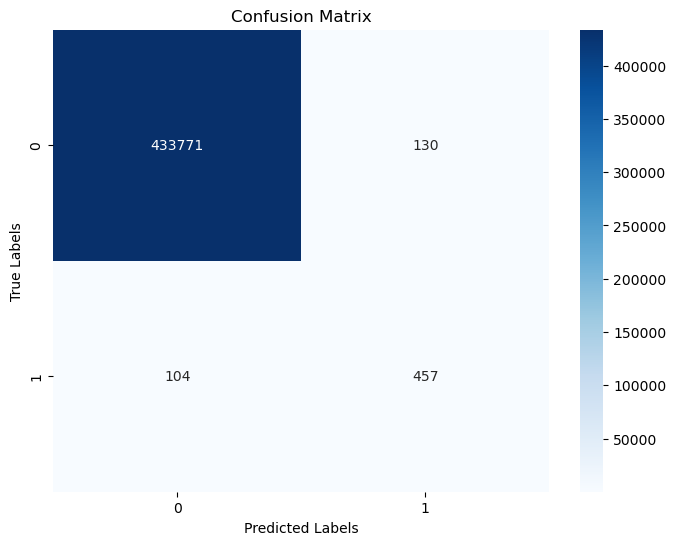

In [356]:
# Calculating Confusion Matrix
confusion_mtx_f = confusion_matrix(comp_df['Probability_category'].values,
                                   comp_df['Prediction_category'].values
                                  )

# Ploting
plt.figure(figsize=(8, 6))

sns.heatmap(confusion_mtx_f, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()


*Financing products* typically have higher costs compared to other products, which leads to an expectation of lower wealth among customers. As a result, we observe a significant number of 0s in the data, indicating customers who do not purchase financing products. This pattern is reflected in the confusion matrix, where there is a tendency towards True Negative (TN) values.

Given the nature of financing products, it is not surprising to see relatively few positive values in the confusion matrix. However, among the positive predictions, the majority are True Positive (TP) instances, indicating successful predictions of customers who actually purchase financing products.

In [357]:
# Precision:
precision = confusion_mtx_f[1, 1] / (confusion_mtx_f[1, 1] + confusion_mtx_f[0, 1])
print('Precision:', round(precision, 3))

# Recall (True Positive Rate):
recall = confusion_mtx_f[1, 1] / (confusion_mtx_f[1, 1] + confusion_mtx_f[1, 0])
print('Recall:', round(recall, 3))

# F1-Score:
f1_score = 2 * (precision * recall) / (precision + recall)
print('F1-Score:', round(f1_score, 3))

# Accuracy:
accuracy = (confusion_mtx_f[1, 1] + confusion_mtx_f[0, 0]) / (confusion_mtx_f[1, 1] + confusion_mtx_f[0, 0] + confusion_mtx_f[0, 1] + confusion_mtx_f[1, 0])
print('Accuracy:', round(accuracy, 3))

# Calculating AUC-ROC score
auc_roc = roc_auc_score(comp_df['Probability_category'].values,
                        comp_df['Prediction_category'].values,
                        multi_class='ovr'
                       )

print("AUC-ROC Score:", round(auc_roc, 3))

Precision: 0.779
Recall: 0.815
F1-Score: 0.796
Accuracy: 0.999
AUC-ROC Score: 0.907


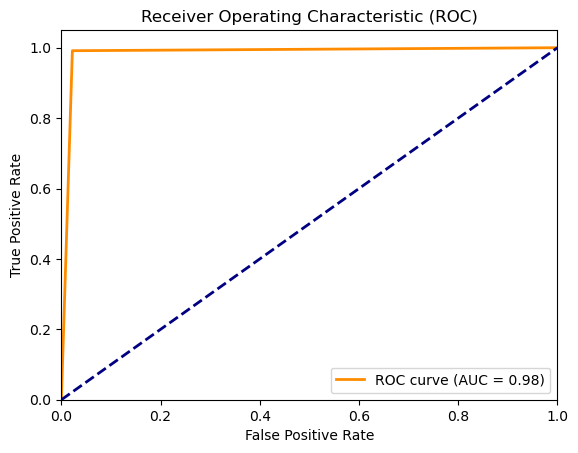

In [358]:
fpr, tpr, thresholds = roc_curve(comparable_df['Probability_category'].values,
                                 comparable_df['Prediction_category'].values
                                )
roc_auc = auc(fpr, tpr)

# Plotting ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

plt.show()


Text(0.5, 0, 'Feature Importance')

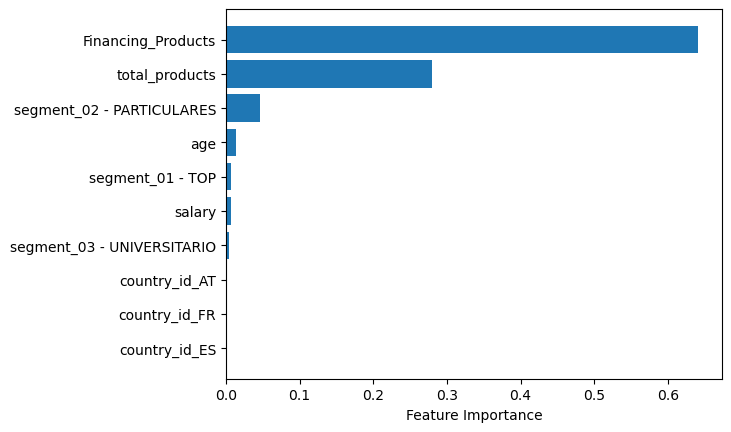

In [359]:
# Arranging features in increasing order of importance.
importances = rf_model.feature_importances_
sorted_idx = importances.argsort()

plt.barh(selected_col.columns[sorted_idx][-10:],
         importances[sorted_idx][-10:]
        )

plt.xlabel("Feature Importance")


As anticipated, the most influential feature for predicting the purchase of Financing Products is the customer's previous history of purchasing such products. This indicates that past behavior strongly influences future decisions.

The total number of products purchased by the customer is the second most relevant feature. Customers who have a higher overall engagement with the company and have purchased multiple products are more likely to consider financing products.

Although not as significant as the previous features, belonging to the PARTICULARES segment still plays a role in influencing the decision to purchase financing products. This segment-specific characteristic may be indicative of certain customer preferences or needs.

The age of the customer follows as a moderately influential feature. Different age groups may have varying financial needs and considerations, leading to differences in their propensity to purchase financing products.

Affiliation with the TOP segment is also a relevant feature, indicating that customers with a higher status or financial capability are more likely to be interested in financing options.

Both the customer's salary and affiliation with the UNIVERSITARIO segment have an impact on the decision to purchase financing products. Higher salaries and association with the UNIVERSITARIO segment may suggest a higher capacity for financial investment.

Similar to the other product types, the customer's country of origin does not appear to have a significant influence on the decision to purchase financing products. It suggests that customer behavior in relation to financing products is relatively consistent across different countries.

Overall, these insights from the feature analysis provide valuable information for understanding the factors that drive customer decisions in purchasing financing products.

# Selecting the most relevant customers

Based on Erin's email, *the company has a budget to send 10 000 emails to different customers*, with the goal of targeting those who are most likely to make a purchase. In order to determine which customers to select, we will consider the revenue associated with each product type.

Given the revenue figures provided, which are approximately €10 for each account sold, €40 for savings and investment products, and €60 for financing products, we can calculate the potential revenue for each customer based on the previously calculated predictions for each product type.

**By summing up the predictions of customer spending for Account Sold, Savings & Investment, and Financing Products**, we can calculate the total predicted revenue for each customer. This enables us to identify the customers who are projected to generate the highest revenue across these product categories. With this information in hand, we will select the top 10,000 customers with the highest predicted revenue and target them for the promotional emails.

This approach allows us to **prioritize the customers who are most likely to generate revenue for the company, maximizing the potential return on investment for the email campaign.**

In [360]:
# Each Account Sold costs 10€
comparable_df['Account_Sold_Prediction'] = comparable_df['Prediction'] * 10
comparable_df

pk_cid  Prediction  Probability  Probability_category  \
0         16063    0.256450     0.256450                     0   
1         16203    0.894664     0.894664                     1   
2         16502    0.831537     0.831537                     1   
3         17457    0.838741     0.838741                     1   
4         17590    0.256572     0.256572                     0   
...         ...         ...          ...                   ...   
434457  1548202    0.798289     0.227138                     0   
434458  1548203    0.831537     0.256450                     0   
434459  1548204    0.256450     0.256450                     0   
434460  1548206    0.256450     0.256450                     0   
434461  1548207    0.227138     0.227138                     0   

        Prediction_category  Account_Sold_Prediction  
0                         0                 2.564498  
1                         1                 8.946645  
2                         1                 8.315368  
3                         1                 8.387408  
4                         0                 2.565723  
...                     ...                      ...  
434457                    1                 7.982894  
434458                    1                 8.315368  
434459                    0                 2.564498  
434460                    0                 2.564498  
434461                    0                 2.271383  

[434462 rows x 6 columns]

In [361]:
# Each Savings & Investments costs 40€
compare_df['Saving_Investment_Prediction'] = compare_df['Prediction'] * 40
compare_df

pk_cid  Prediction  Probability  Probability_category  \
0         16063    0.008531     0.008531                     0   
1         16203    0.186898     0.186898                     0   
2         16502    0.055807     0.055807                     0   
3         17457    0.391331     0.391331                     0   
4         17590    0.034240     0.034240                     0   
...         ...         ...          ...                   ...   
434457  1548202    0.012877     0.012064                     0   
434458  1548203    0.009344     0.008531                     0   
434459  1548204    0.008531     0.008531                     0   
434460  1548206    0.005672     0.005672                     0   
434461  1548207    0.012064     0.012064                     0   

        Prediction_category  Saving_Investment_Prediction  
0                         0                      0.341240  
1                         0                      7.475919  
2                         0                      2.232282  
3                         0                     15.653231  
4                         0                      1.369612  
...                     ...                           ...  
434457                    0                      0.515088  
434458                    0                      0.373764  
434459                    0                      0.341240  
434460                    0                      0.226895  
434461                    0                      0.482563  

[434462 rows x 6 columns]

In [362]:
# Each Financing Product costs 60€
comp_df['Financing_Product_Prediction'] = comp_df['Prediction'] * 60
comp_df

pk_cid  Prediction  Probability  Probability_category  \
0         16063    0.016584     0.016584                     0   
1         16203    0.021501     0.021501                     0   
2         16502    0.016584     0.016584                     0   
3         17457    0.023506     0.023506                     0   
4         17590    0.023506     0.023506                     0   
...         ...         ...          ...                   ...   
434457  1548202    0.009946     0.009946                     0   
434458  1548203    0.016584     0.016584                     0   
434459  1548204    0.016584     0.016584                     0   
434460  1548206    0.016584     0.016584                     0   
434461  1548207    0.016584     0.016584                     0   

        Prediction_category  Financing_Product_Prediction  
0                         0                      0.995017  
1                         0                      1.290068  
2                         0                      0.995017  
3                         0                      1.410357  
4                         0                      1.410357  
...                     ...                           ...  
434457                    0                      0.596781  
434458                    0                      0.995017  
434459                    0                      0.995017  
434460                    0                      0.995017  
434461                    0                      0.995017  

[434462 rows x 6 columns]

In [363]:
# Merging the features in a DF
relevant_customers_df = comparable_df[['pk_cid', 'Account_Sold_Prediction']].merge(compare_df[['pk_cid', 'Saving_Investment_Prediction']], on='pk_cid').merge(comp_df[['pk_cid', 'Financing_Product_Prediction']], on='pk_cid')
relevant_customers_df

pk_cid  Account_Sold_Prediction  Saving_Investment_Prediction  \
0         16063                 2.564498                      0.341240   
1         16203                 8.946645                      7.475919   
2         16502                 8.315368                      2.232282   
3         17457                 8.387408                     15.653231   
4         17590                 2.565723                      1.369612   
...         ...                      ...                           ...   
434457  1548202                 7.982894                      0.515088   
434458  1548203                 8.315368                      0.373764   
434459  1548204                 2.564498                      0.341240   
434460  1548206                 2.564498                      0.226895   
434461  1548207                 2.271383                      0.482563   

        Financing_Product_Prediction  
0                           0.995017  
1                           1.290068  
2                           0.995017  
3                           1.410357  
4                           1.410357  
...                              ...  
434457                      0.596781  
434458                      0.995017  
434459                      0.995017  
434460                      0.995017  
434461                      0.995017  

[434462 rows x 4 columns]

In [364]:
# Summing up Account Sold, Savings & Investment, and Financing Products for each customer
relevant_customers_df['Total_Money_Prediction'] = relevant_customers_df['Account_Sold_Prediction'] + relevant_customers_df['Saving_Investment_Prediction'] + relevant_customers_df['Financing_Product_Prediction']
relevant_customers_df

pk_cid  Account_Sold_Prediction  Saving_Investment_Prediction  \
0         16063                 2.564498                      0.341240   
1         16203                 8.946645                      7.475919   
2         16502                 8.315368                      2.232282   
3         17457                 8.387408                     15.653231   
4         17590                 2.565723                      1.369612   
...         ...                      ...                           ...   
434457  1548202                 7.982894                      0.515088   
434458  1548203                 8.315368                      0.373764   
434459  1548204                 2.564498                      0.341240   
434460  1548206                 2.564498                      0.226895   
434461  1548207                 2.271383                      0.482563   

        Financing_Product_Prediction  Total_Money_Prediction  
0                           0.995017                3.900755  
1                           1.290068               17.712632  
2                           0.995017               11.542666  
3                           1.410357               25.450996  
4                           1.410357                5.345691  
...                              ...                     ...  
434457                      0.596781                9.094763  
434458                      0.995017                9.684149  
434459                      0.995017                3.900755  
434460                      0.995017                3.786411  
434461                      0.995017                3.748963  

[434462 rows x 5 columns]

In [365]:
# Sorting the DF by Total Money Spent (Prediction)
sorted_df = relevant_customers_df.sort_values('Total_Money_Prediction', ascending=False)
top_customers = sorted_df.head(10000)
top_customers

pk_cid  Account_Sold_Prediction  Saving_Investment_Prediction  \
211117  1269374                 9.591728                     31.702582   
15959   1019169                 9.631087                     31.702582   
18138   1022686                 9.631087                     31.702582   
13296   1014752                 9.631087                     31.702582   
102903  1128353                 9.631087                     31.702582   
...         ...                      ...                           ...   
372443  1469935                 8.315368                      1.186214   
411493  1514371                 8.315368                      1.186214   
15701   1018744                 8.315368                      1.186214   
433209  1546434                 8.315368                      1.186214   
347624  1441386                 8.315368                      1.186214   

        Financing_Product_Prediction  Total_Money_Prediction  
211117                     42.489300               83.783611  
15959                      40.659065               81.992734  
18138                      40.659065               81.992734  
13296                      40.659065               81.992734  
102903                     40.659065               81.992734  
...                              ...                     ...  
372443                     10.679546               20.181128  
411493                     10.679546               20.181128  
15701                      10.679546               20.181128  
433209                     10.679546               20.181128  
347624                     10.679546               20.181128  

[10000 rows x 5 columns]

**These are the 10 000 customers identified as the most likely to make a purchase** across any of the three product types: Account Sold, Savings & Investment, and Financing Products. Based on this analysis, I recommend sending promotional emails to these customers, as they have a higher likelihood of engaging with our offerings and making a purchase.

# Maximizing Email Campaign Impact

As an additional bonus, and subject to budget availability, I have provided you with a list of the top 1000 customers who are most likely to purchase each type of product. This valuable information will enable the marketing department to personalize each email based on the specific preferences and interests of these customers. By tailoring the content to their individual needs, we can significantly enhance the effectiveness of our email campaign and drive higher conversion rates.

In [366]:
# Customers most likely to purchase Account Sold
top_customers_account_sold = sorted_df.sort_values('Account_Sold_Prediction', ascending=False).head(1000)
top_customers_account_sold.drop(['Saving_Investment_Prediction', 'Financing_Product_Prediction'], axis=1, inplace=True)
top_customers_account_sold

pk_cid  Account_Sold_Prediction  Total_Money_Prediction
5642    1001761                 9.954499               11.447364
160772  1201784                 9.946892               10.036353
171071  1213372                 9.946892               10.036353
286473  1359725                 9.946892               10.036353
286474  1359726                 9.946892               10.036353
...         ...                      ...                     ...
285997  1359152                 9.946892               10.036353
164959  1206473                 9.946892               10.036353
170650  1212844                 9.946892               10.036353
170627  1212819                 9.946892               10.036353
283572  1356402                 9.946892               10.036353

[1000 rows x 3 columns]

In [367]:
# Customers most likely to purchase Saving & Investment Products
top_customers_saving_investment = sorted_df.sort_values('Saving_Investment_Prediction', ascending=False).head(1000)
top_customers_saving_investment.drop(['Account_Sold_Prediction', 'Financing_Product_Prediction'], axis=1, inplace=True)
top_customers_saving_investment

pk_cid  Saving_Investment_Prediction  Total_Money_Prediction
211073  1269296                     39.431346               50.762917
2213     539016                     32.608710               47.380382
213003  1271794                     31.887574               42.810455
97572   1119280                     31.887574               42.810455
211117  1269374                     31.702582               83.783611
...         ...                           ...                     ...
196170  1245634                     31.702582               42.091544
310633  1392659                     31.702582               42.091544
104362  1133823                     31.702582               42.091544
238331  1303863                     31.702582               42.091544
232855  1296573                     31.702582               42.091544

[1000 rows x 3 columns]

In [368]:
# Customers most likely to purchase Financing Products
top_customers_financing = sorted_df.sort_values('Financing_Product_Prediction', ascending=False).head(1000)
top_customers_financing.drop(['Account_Sold_Prediction', 'Saving_Investment_Prediction'], axis=1, inplace=True)
top_customers_financing

pk_cid  Financing_Product_Prediction  Total_Money_Prediction
201544  1254326                     52.998382               62.048696
73121   1088731                     51.440013               54.338667
150971  1190897                     51.274535               61.128332
8566    1007208                     51.274535               61.128332
199248  1250781                     51.274535               54.378269
...         ...                           ...                     ...
67033   1081644                     27.184813               36.669822
5474    1001492                     27.184813               36.428228
15977   1019201                     27.184813               36.496534
106479  1137297                     27.184813               36.428228
101456  1126000                     27.184813               36.428228

[1000 rows x 3 columns]

# Project Conclusion

Through my comprehensive analysis, I have successfully developed a predictive model that identifies customers who are most likely to make purchases in various product categories. By leveraging machine learning techniques, I have generated accurate predictions for Account Sold, Savings & Investment, and Financing Products, allowing me to prioritize and target my marketing efforts effectively.

My model achieved impressive performance, with high precision, recall, and F1-score metrics, indicating its ability to correctly classify customer behavior. Additionally, the AUC-ROC score demonstrated the model's capability to discriminate between positive and negative outcomes.

By applying the model to a test dataset, I was able to assess its performance and generate valuable insights. The confusion matrix provided a visual representation of the model's predictive accuracy, while the feature importance analysis highlighted the key factors influencing customer spending behavior.

Building upon this foundation, I further refined my approach by selecting the top 10,000 customers who are most likely to make purchases across all three product types. Additionally, I identified the top 1,000 customers for each specific product category. These insights enable me to tailor personalized marketing strategies and email campaigns, maximizing the potential for revenue generation.

In conclusion, my data-driven analysis and predictive modeling have empowered me to effectively target and engage customers with the highest propensity to purchase. By leveraging these insights, I can optimize my marketing efforts, drive customer engagement, and ultimately achieve my objective of increasing sales and revenue.